## Как узнать свою аудиторию? Построение различных вариантов кластеризаций и интерпретация результатов. 

В работе датасет с данными о клиентах немецкого банка. Необходимо разбить клиентов на группы и объяснить, чем полученные группы отличаются друг от друга.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN


from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings("ignore")


In [37]:
data = pd.read_csv("D:/AI__2022/OTUS/Домашки/8__иерархическая кластеризация_DBSCAN/german_credit_data.csv")
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


## 1. EDA & Preprocessing

In [3]:
data.describe()

,Unnamed: 0,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


In [4]:
data.isna().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


In [6]:
data.duplicated().sum()

0

In [7]:
data.nunique()

Unnamed: 0          1000
Age                   53
Sex                    2
Job                    4
Housing                3
Saving accounts        4
Checking account       3
Credit amount        921
Duration              33
Purpose                8
dtype: int64

Всего 10 признаков. Дубликатов нет, в признаках <b>"Saving accounts" и "Checking account"</b> имеются пропуски. Посмотрим на значения в данных признаках. Уникальный признак только один - <b>"Unnamed: 0"</b>

In [8]:
data['Saving accounts'].value_counts(normalize=True, dropna=False)

little        0.603
NaN           0.183
moderate      0.103
quite rich    0.063
rich          0.048
Name: Saving accounts, dtype: float64

In [9]:
data['Checking account'].value_counts(normalize=True, dropna=False)

NaN         0.394
little      0.274
moderate    0.269
rich        0.063
Name: Checking account, dtype: float64

Признаки <b>"Saving accounts" и "Checking account"</b> категориальные, перекодируем их вместе с пропусками в числовые категории методом dummies. Пропуски закодируются вектором, состоящим из нулей.

In [10]:
data = pd.get_dummies(data=data, columns=['Saving accounts', 'Checking account'])

Проверим кол-во значений в признаках <b>"Sex", "Job", "Housing" и "Purpose"</b>.

In [11]:
data[['Sex', 'Job', 'Housing', 'Purpose']].nunique()

Sex        2
Job        4
Housing    3
Purpose    8
dtype: int64

Закодируем указанные выше признаки подходящими методами. При кодировке методом dummies удалим первые признаки, чтобы не увеличивать размерность датасета.

In [12]:
labelencoder = LabelEncoder()
data['Sex'] = labelencoder.fit_transform(data['Sex'])
data = pd.get_dummies(data=data, columns=['Job', 'Housing', 'Purpose'], drop_first=True)

Приведем названия признаков к нижнему регистру и удалим пробелы.

In [13]:
data.columns = data.columns.str.lower().str.replace(" ", "_")
data.columns

Index(['unnamed:_0', 'age', 'sex', 'credit_amount', 'duration',
       'saving_accounts_little', 'saving_accounts_moderate',
       'saving_accounts_quite_rich', 'saving_accounts_rich',
       'checking_account_little', 'checking_account_moderate',
       'checking_account_rich', 'job_1', 'job_2', 'job_3', 'housing_own',
       'housing_rent', 'purpose_car', 'purpose_domestic_appliances',
       'purpose_education', 'purpose_furniture/equipment', 'purpose_radio/tv',
       'purpose_repairs', 'purpose_vacation/others'],
      dtype='object')

In [14]:
sum(data.index - data['unnamed:_0'])

0

Признак <b>'unnamed:_0'</b> идентичен индексу, его нужно удалить.

In [15]:
data.drop(columns='unnamed:_0', inplace=True)

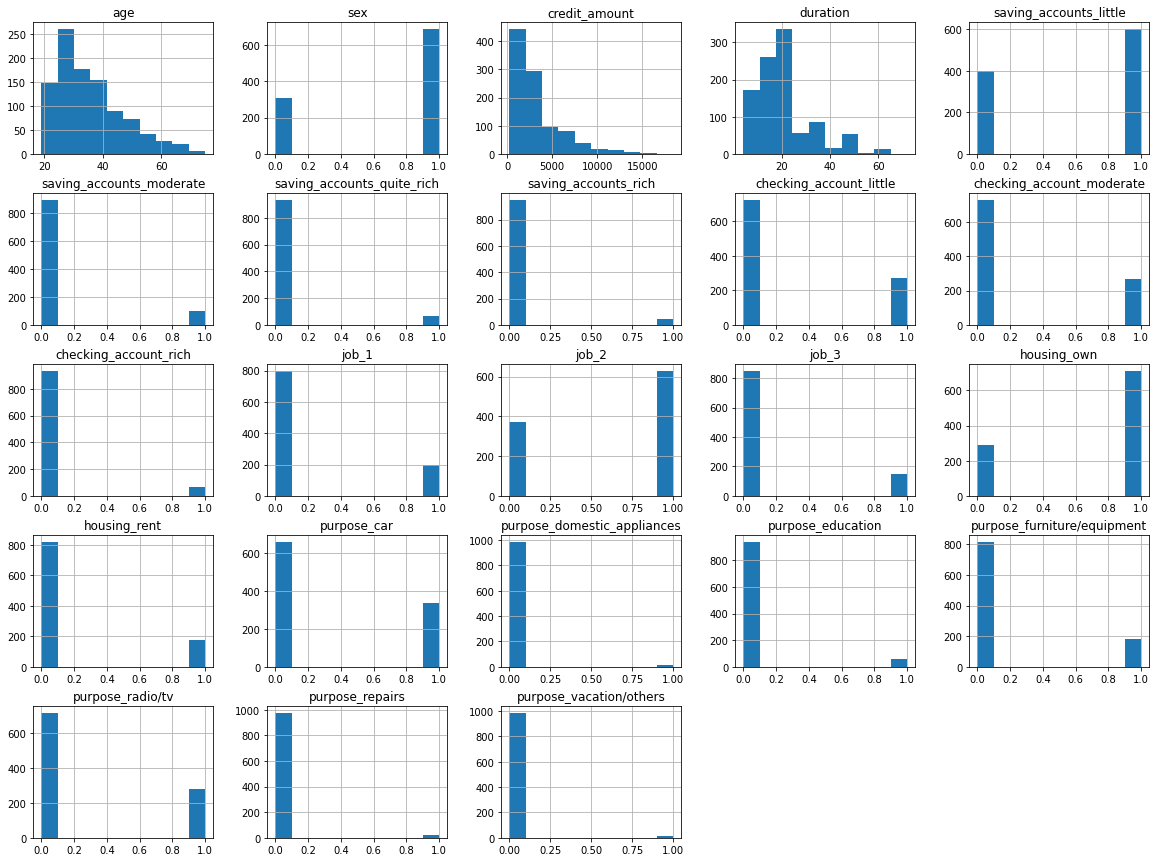

In [16]:
data.hist(figsize=(20, 15))
plt.show()

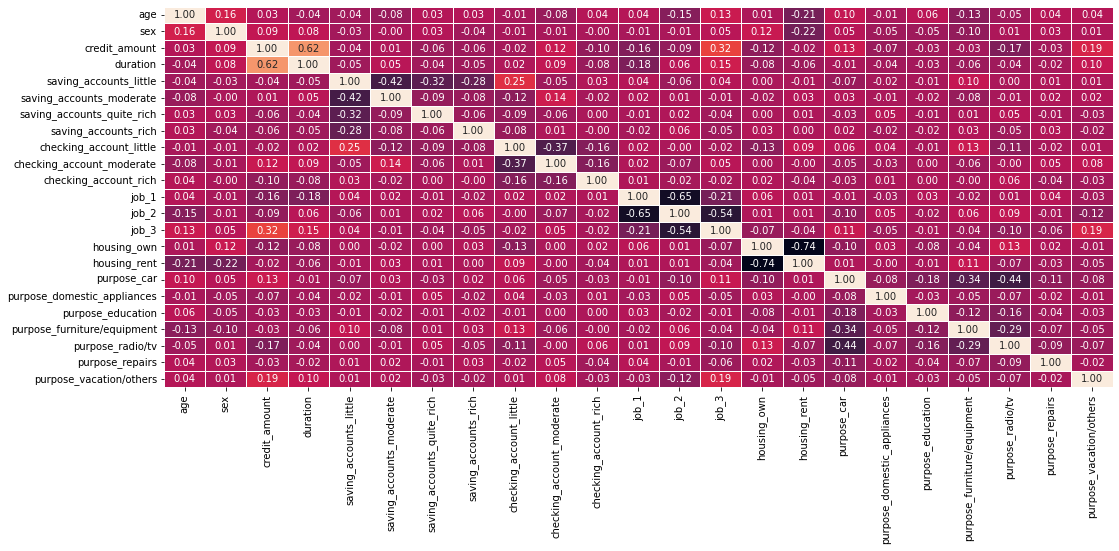

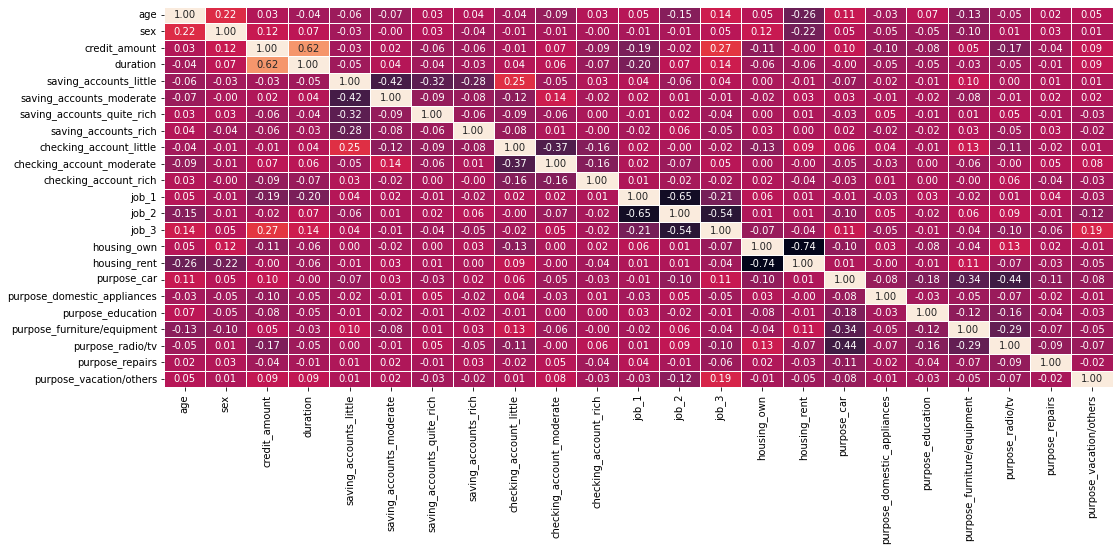

In [17]:
plt.figure(figsize=(17, 7))
sns.heatmap(data.corr(method='pearson'), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()
plt.figure(figsize=(17, 7))
sns.heatmap(data.corr(method='spearman'), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

Наиболее сильная корреляция (обратная) у признаков <b>"housing_rent" и "housing_own"</b>, это объясняется тем, что они описывают одно и тоже состояние кредитора - статус владения жилым имуществом. Таким образом, удалять по корреляционной связи нечего.

Проверим оставшиеся числовые признаки на выбросы.

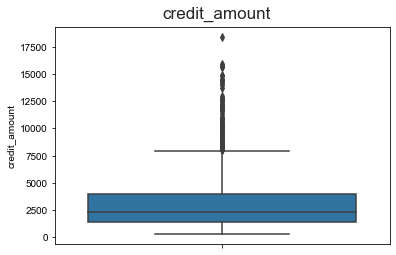

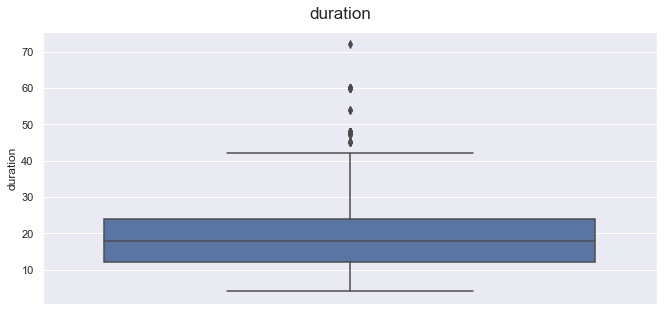

In [18]:
for column in ['credit_amount', 'duration']:
    sns.boxplot(y=data[column])
    sns.set(rc={'figure.figsize':(11, 5)})
    plt.suptitle(column, fontsize=17, y=0.95)
    plt.show()

Для обучения с учителем значения с превышением верхней границы ящика на 3 межквартильных интервала следовало бы удалить. Но для задачи кластеризации этого можно не делать, тем более что данные значения вполне могут быть реальными.

Приведем все признаки к единому масштабу (т.е. к диапазону [0,1]). Масштабирование необходимо для корректного формирования кластеров, т.к. модели кластеризации формируют кластера при помощи евклидова расстояния между объектами. Разный масштаб признаков приведет к смещению точек относительно их реального положения и неккоректному формированию кластеров.

In [19]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

## 2. Modeling

Построим три модели кластеризации (KMeans, AgglomerativeClustering, DBSCAN) и подберем оптимальное кол-во кластеров для каждой из них.

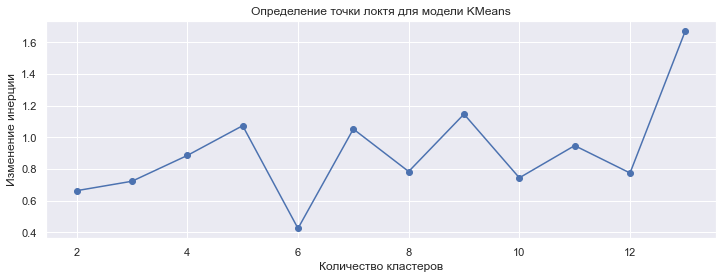

In [20]:
def kmeans_clusters(data,max_clusters):

    inertia = []

    for k in range(1, max_clusters):

        kmeans = KMeans(n_clusters=k, random_state=800).fit(data)
        
        inertia.append(np.sqrt(kmeans.inertia_))

    d = {}
    for k in range(2, max_clusters-1):
        i = k - 1
        d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

    plt.figure(figsize=(12, 4))
    plt.plot(range(2, max_clusters-1), [x for x in d.values()], marker='o')

    plt.title('Определение точки локтя для модели KMeans')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Изменение инерции')

    plt.show()

kmeans_clusters(data_scaled,15)

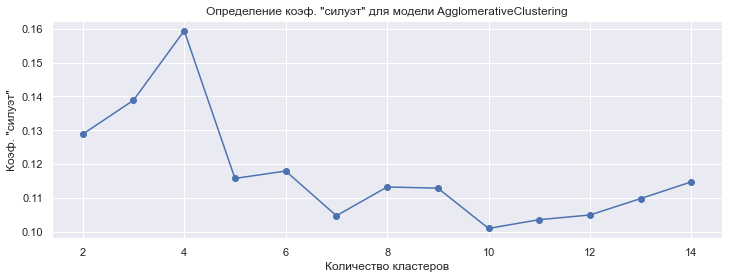

In [21]:
def agglomerative_clusters(data,min_clusters,max_clusters):

    silhouette = []
    for i in range(min_clusters,max_clusters):
        agg = AgglomerativeClustering(n_clusters=i).fit(data)
        labels = agg.labels_
        score = silhouette_score(data, labels)
        silhouette.append(score)

    plt.figure(figsize=(12, 4))
    plt.plot(range(min_clusters,max_clusters), silhouette, marker='o')

    plt.title('Определение коэф. "силуэт" для модели AgglomerativeClustering')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Коэф. "силуэт"')

    plt.show()

agglomerative_clusters(data_scaled, 2, 15)

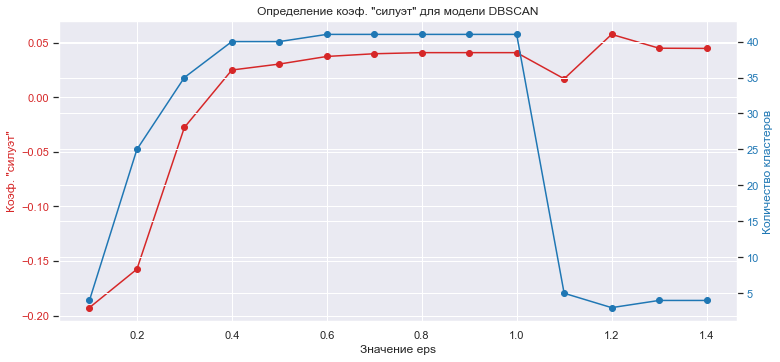

In [22]:
def dbscan_clusters(data,min_clusters,max_clusters,step):

    silhouette = []
    clusters = []
    eps_range = np.arange(min_clusters,max_clusters,step)
    for i in eps_range:
        dbscan = DBSCAN(eps=i, min_samples=5).fit(data)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(data, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)


    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(eps_range, silhouette, marker='o', color=color)
    ax1.set_xlabel('Значение eps')
    ax1.set_ylabel('Коэф. "силуэт"', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax2.plot(eps_range, clusters, marker='o', color=color)
    ax2.set_ylabel('Количество кластеров', color=color)  
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()

    plt.title('Определение коэф. "силуэт" для модели DBSCAN')

    plt.show()

dbscan_clusters(data_scaled, 0.1, 1.5, 0.1)

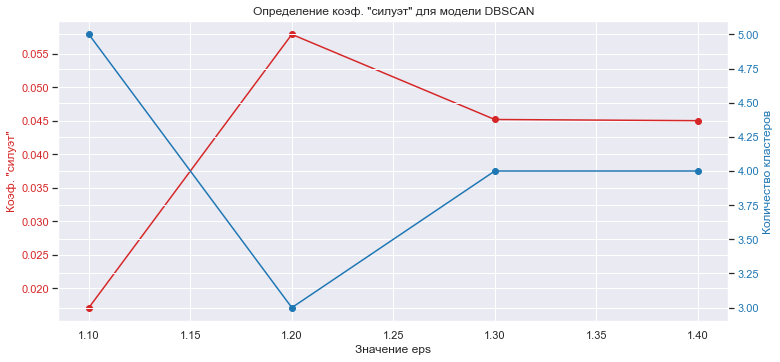

In [23]:
dbscan_clusters(data_scaled, 1.1, 1.5, 0.1)

Для модели KMeans оптимальное число кластеров равно 6, для AgglomerativeClustering - 4, для DBSCAN - 3 (при eps = 1.2). Обучим модели с указанными гиперпараметрами.

In [24]:
kmeans = KMeans(n_clusters=6, random_state=800).fit(data_scaled)
agg = AgglomerativeClustering(n_clusters=4).fit(data_scaled)
dbscan = DBSCAN(eps=1.2, min_samples=5).fit(data_scaled)


Понизим размерность датасета методами PCA, tSNE, UMAP для отображения результатов кластеризации на двумерной плоскости.

In [25]:
def data_reduced(data,method):

    if method == PCA:
        data_reduced = PCA(n_components=2).fit_transform(data)
        method_name = 'PCA'

    elif method == TSNE:
        data_reduced = TSNE(n_components=2, random_state=800, n_jobs=-1).fit_transform(data)
        method_name = 'tSNE'

    else: 
        data_reduced = umap.UMAP(n_components=2, random_state=800, n_jobs=-1).fit_transform(data)
        method_name = 'UMAP'


    plt.figure(figsize=(14, 7))
    ax = sns.scatterplot(x=data_reduced[:,0], y=data_reduced[:,1], hue=kmeans.labels_, palette='coolwarm')
    ax.set(xlabel='Главный компонент №1', ylabel='Главный компонент №2', title='Отображение исходного датасета по 2м главным компонентам методом {} с кластеризацией моделью KMeans'.format(method_name))
    plt.show()

    plt.figure(figsize=(14, 7))
    ax = sns.scatterplot(x=data_reduced[:,0], y=data_reduced[:,1], hue=agg.labels_, palette='coolwarm')
    ax.set(xlabel='Главный компонент №1', ylabel='Главный компонент №2', title='Отображение исходного датасета по 2м главным компонентам методом {} с кластеризацией моделью AgglomerativeClustering'.format(method_name))
    plt.show()

    plt.figure(figsize=(14, 7))
    ax = sns.scatterplot(x=data_reduced[:,0], y=data_reduced[:,1], hue=dbscan.labels_, palette='coolwarm')
    ax.set(xlabel='Главный компонент №1', ylabel='Главный компонент №2', title='Отображение исходного датасета по 2м главным компонентам методом {} с кластеризацией моделью DBSCAN'.format(method_name))
    plt.show()


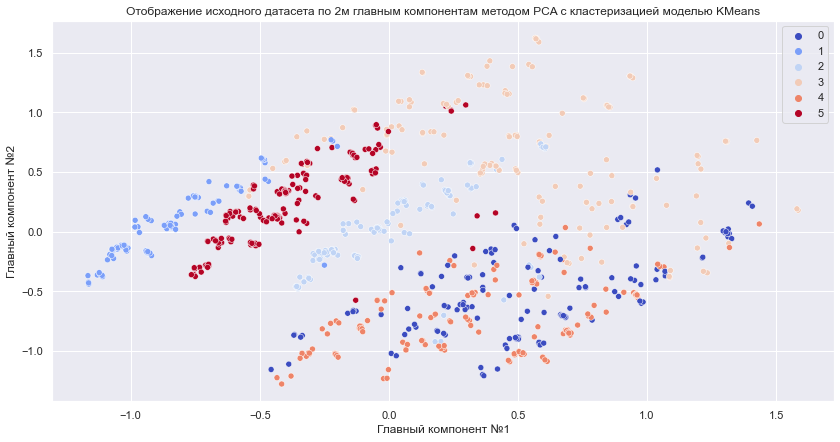

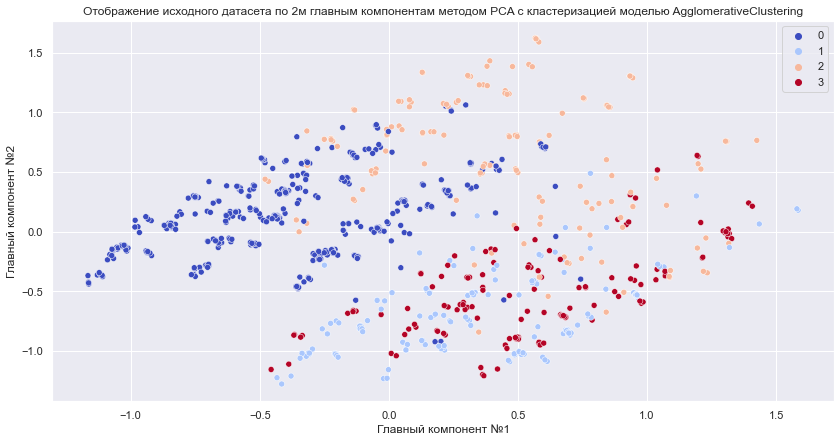

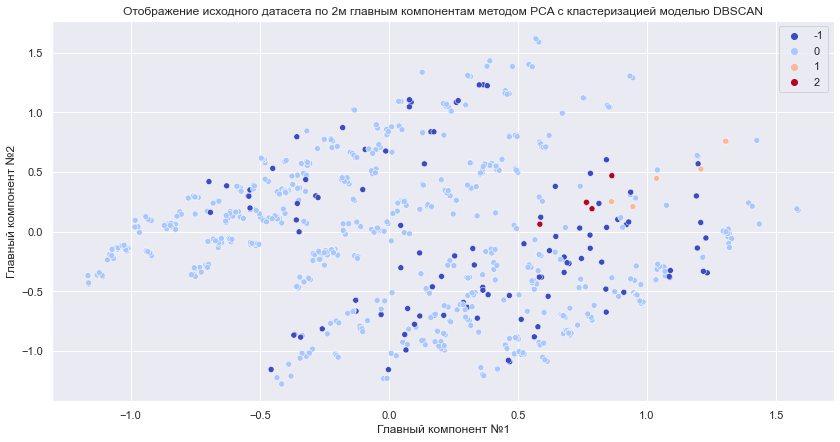

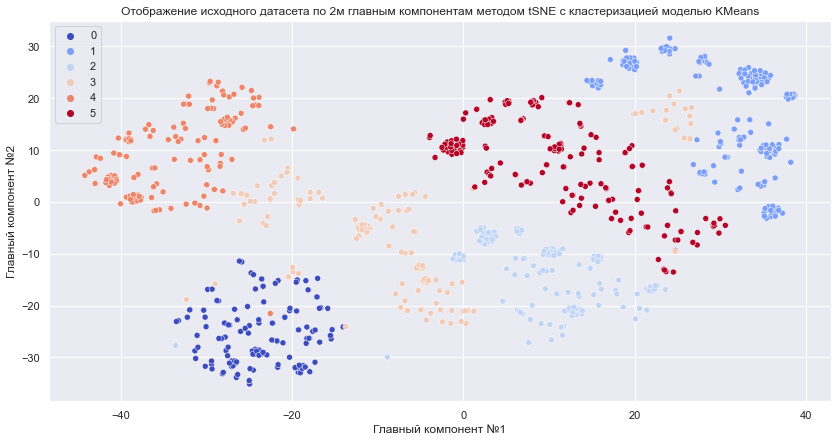

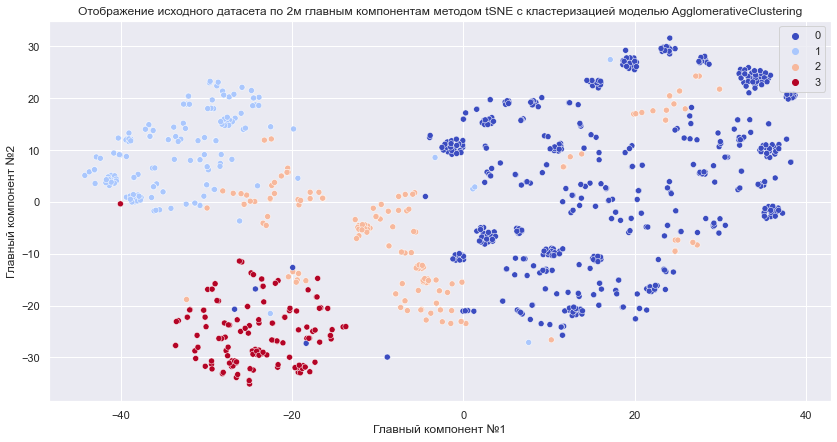

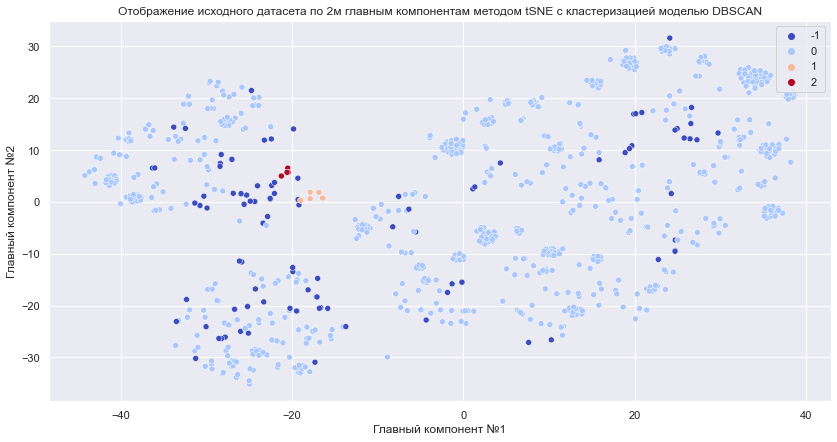

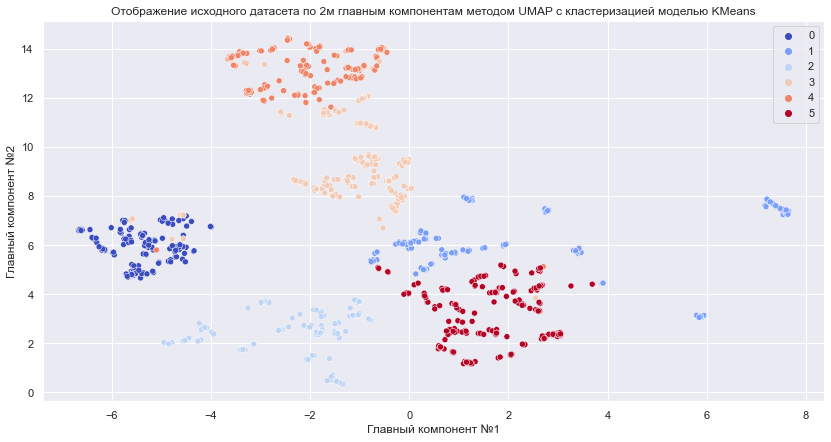

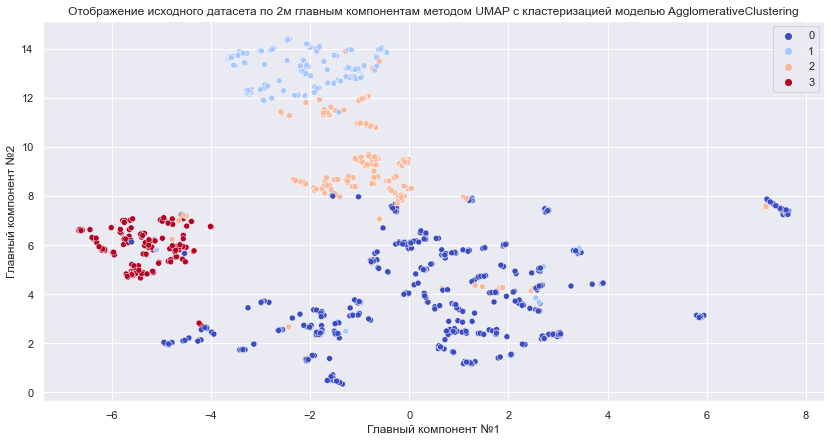

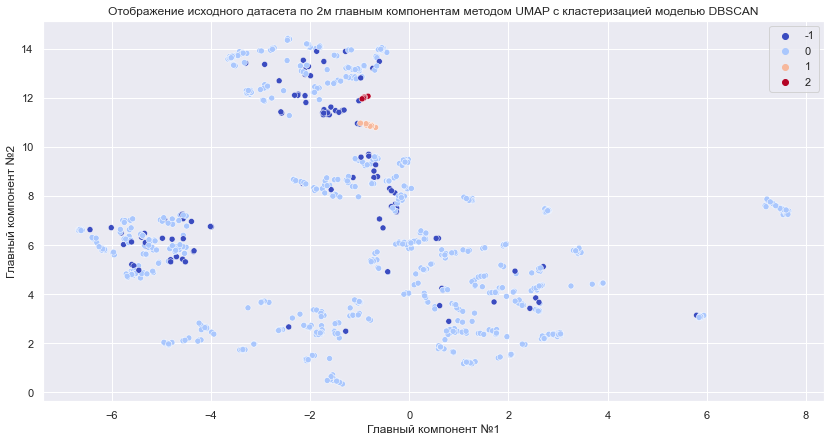

In [26]:
data_reduced(data_scaled,PCA)
data_reduced(data_scaled,TSNE)
data_reduced(data_scaled,umap)

Из представленных комбинаций методов снижения размерности и моделей кластеризации визуально наиболее подходящими выглядят связки tSNE-KMeans, UMAP-KMeans и UMAP-AgglomerativeClustering.

## 3. Interpretation

Посмотрим на средние значения признаков для каждого из кластеров по каждой модели кластеризации.

In [27]:
data_common = pd.DataFrame(data=data_scaled, columns=data.columns)

data_kmeans = data_common.copy()
data_agg = data_common.copy()
data_dbscan = data_common.copy()
data_kmeans['labels'] = kmeans.labels_
data_agg['labels'] = agg.labels_
data_dbscan['labels'] = dbscan.labels_

print("Средние значения признаков для кластеров по модели KMeans", end='\n')
data_kmeans.groupby('labels').mean().T.round(2)

Средние значения признаков для кластеров по модели KMeans


labels,0,1,2,3,4,5
age,0.36,0.28,0.33,0.20,0.33,0.28
sex,0.78,0.70,0.77,0.44,0.71,0.74
credit_amount,0.29,0.13,0.17,0.15,0.12,0.16
duration,0.32,0.25,0.27,0.22,0.18,0.27
saving_accounts_little,0.64,0.60,0.50,0.59,0.66,0.62
saving_accounts_moderate,0.10,0.10,0.13,0.11,0.10,0.08
saving_accounts_quite_rich,0.04,0.06,0.07,0.07,0.05,0.08
saving_accounts_rich,0.01,0.03,0.07,0.05,0.04,0.07
checking_account_little,0.23,0.15,0.29,0.39,0.29,0.29
checking_account_moderate,0.35,0.23,0.22,0.24,0.30,0.28


<u>По модели кластеризации KMeans:</u>
- кластер 0: выделен по статусу работы (job_3);

- кластер 1: выделен по статусу работы (job_2) и цели кредита (радио/тв);

- кластер 2: выделен по статусу работы (job_2) и цели кредита (автомобиль);

- кластер 3: выделен по типу владения жилым имуществом (аренда);

- кластер 4: выделен по статусу работы (job_1) и типу владения жилым имуществом (в собственности);

- кластер 5: выделен по статусу работы (job_2).

In [28]:
print("Средние значения признаков для кластеров по модели AgglomerativeClustering", end='\n')
data_agg.groupby('labels').mean().T.round(2)

Средние значения признаков для кластеров по модели AgglomerativeClustering


labels,0,1,2,3
age,0.29,0.33,0.21,0.37
sex,0.73,0.72,0.47,0.77
credit_amount,0.16,0.11,0.15,0.29
duration,0.26,0.18,0.23,0.31
saving_accounts_little,0.55,0.68,0.65,0.64
saving_accounts_moderate,0.11,0.08,0.11,0.10
saving_accounts_quite_rich,0.07,0.05,0.06,0.04
saving_accounts_rich,0.06,0.05,0.05,0.01
checking_account_little,0.25,0.31,0.36,0.23
checking_account_moderate,0.25,0.28,0.26,0.33


<u>По модели кластеризации AgglomerativeClustering:</u>
- кластер 0: выделен по статусу работы (job_2);

- кластер 1: выделен по статусу работы (job_1);

- кластер 2: типу владения жилым имуществом (аренда);

- кластер 3: выделен по статусу работы (job_3).

In [29]:
print("Средние значения признаков для кластеров по модели DBSCAN", end='\n')
data_dbscan.groupby('labels').mean().T.round(2)

Средние значения признаков для кластеров по модели DBSCAN


labels,-1,0,1,2
age,0.30,0.30,0.10,0.24
sex,0.46,0.72,0.33,0.80
credit_amount,0.15,0.17,0.13,0.09
duration,0.24,0.25,0.20,0.28
saving_accounts_little,0.25,0.64,0.89,0.80
saving_accounts_moderate,0.29,0.08,0.00,0.00
saving_accounts_quite_rich,0.17,0.05,0.00,0.00
saving_accounts_rich,0.11,0.04,0.00,0.00
checking_account_little,0.19,0.28,0.44,1.00
checking_account_moderate,0.36,0.26,0.00,0.00


<u>По модели кластеризации DBSCAN:</u>
- кластер -1 (аномалии): нет явных признаков, по которым выделен кластер - наблюдаются экстремумы среди остальных кластеров в признаках saving_accounts и checking_account;

- кластер 0: нет явных признаков, по которым выделен кластер - наблюдаются экстремумы по статусу работы (job_2) и типу владения жилым имуществом (аренда);

- кластер 1: выделен по статусу работы (job_1), типу владения жилым имуществом (в аренде) и цели кредита (мебель/оборудование);

- кластер 2: выделен по статусу работы (job_1), типу владения жилым имуществом (в аренде) и цели кредита (радио/тв).

Посмотрим на диаграммы размаха по каждой модели.

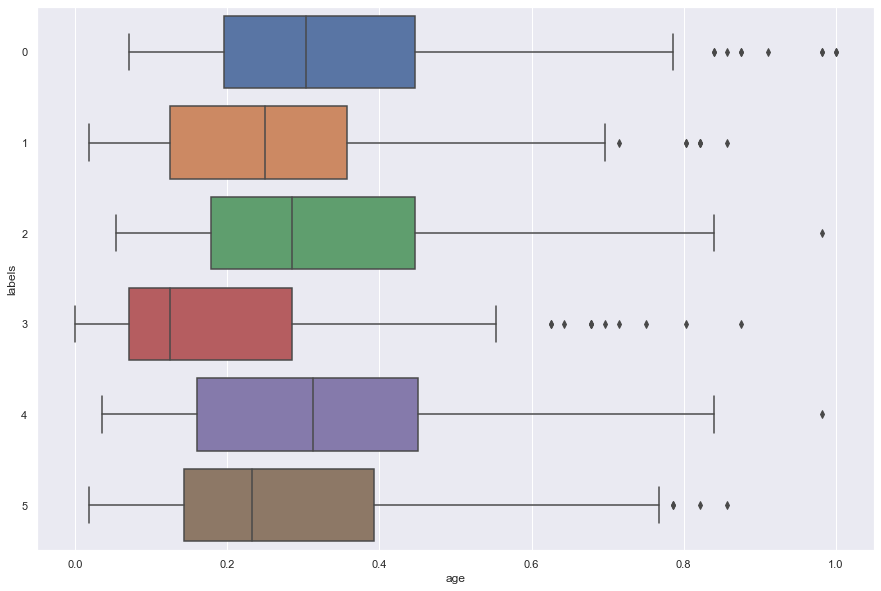

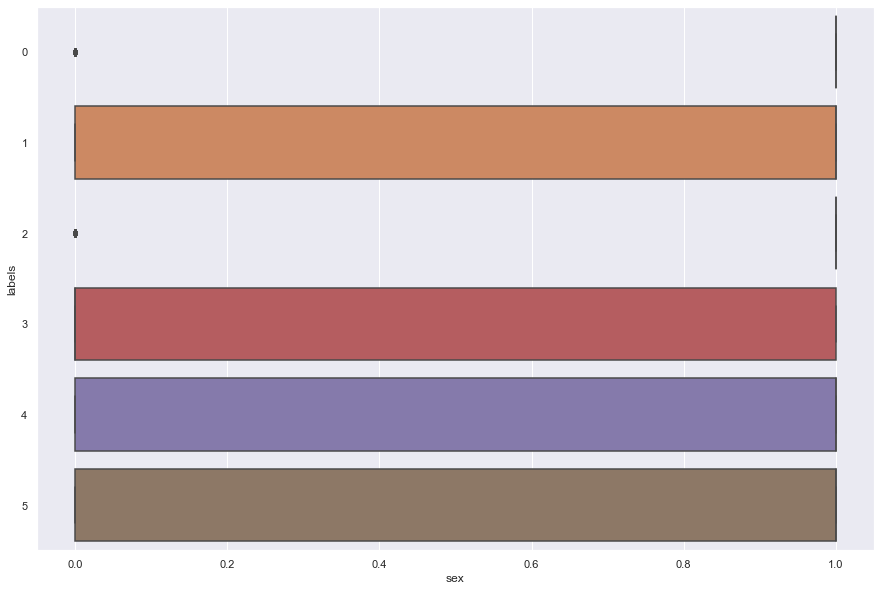

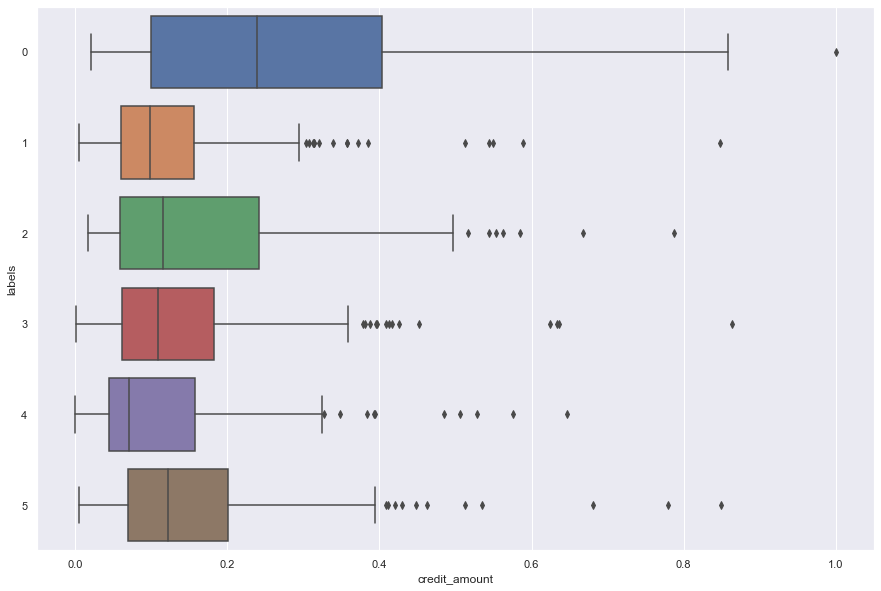

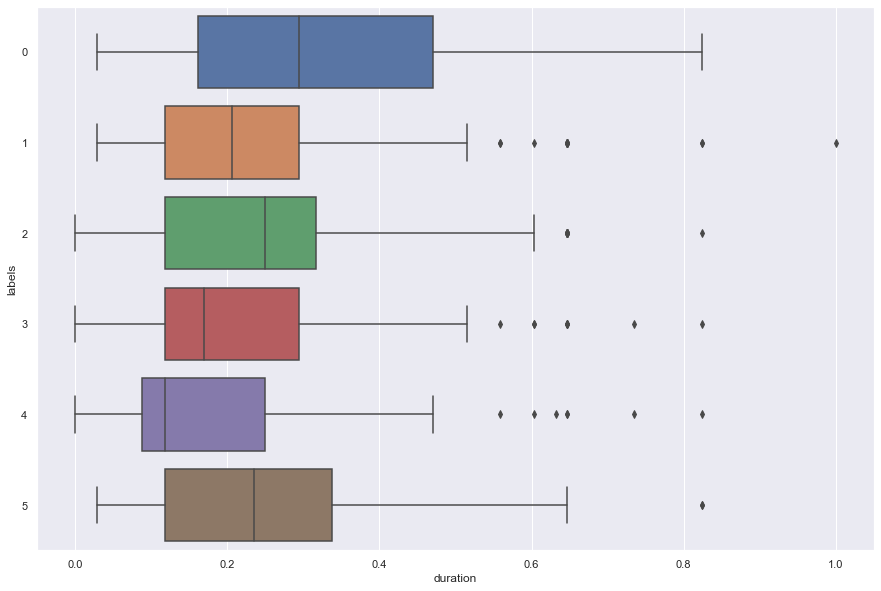

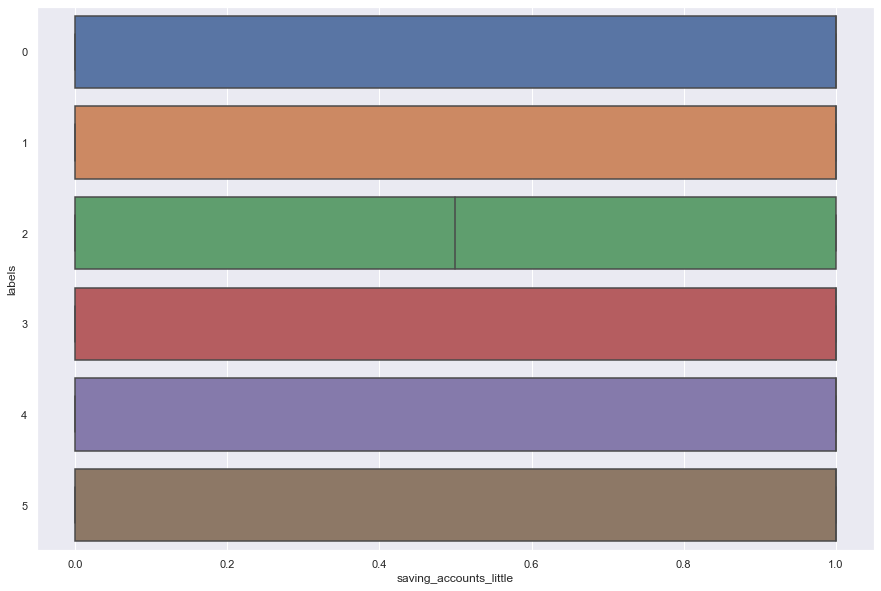

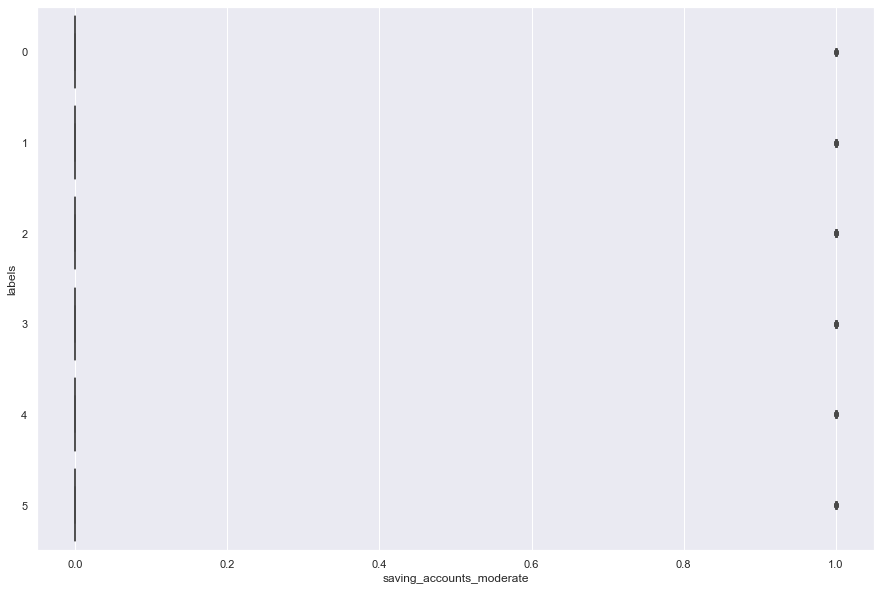

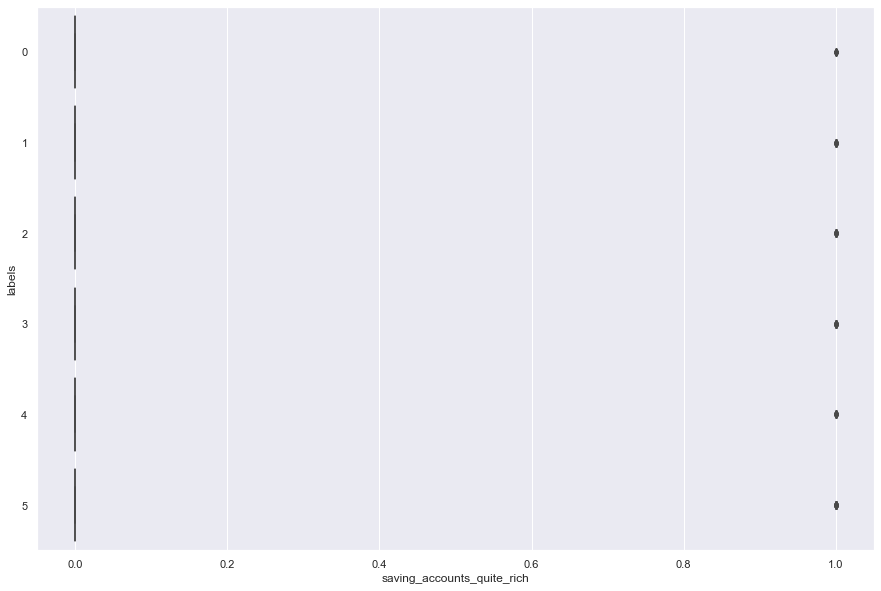

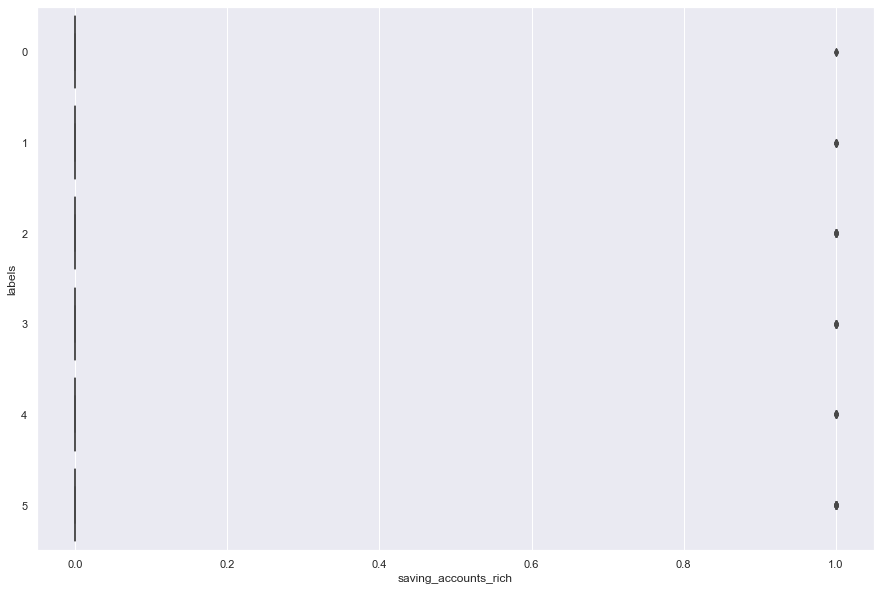

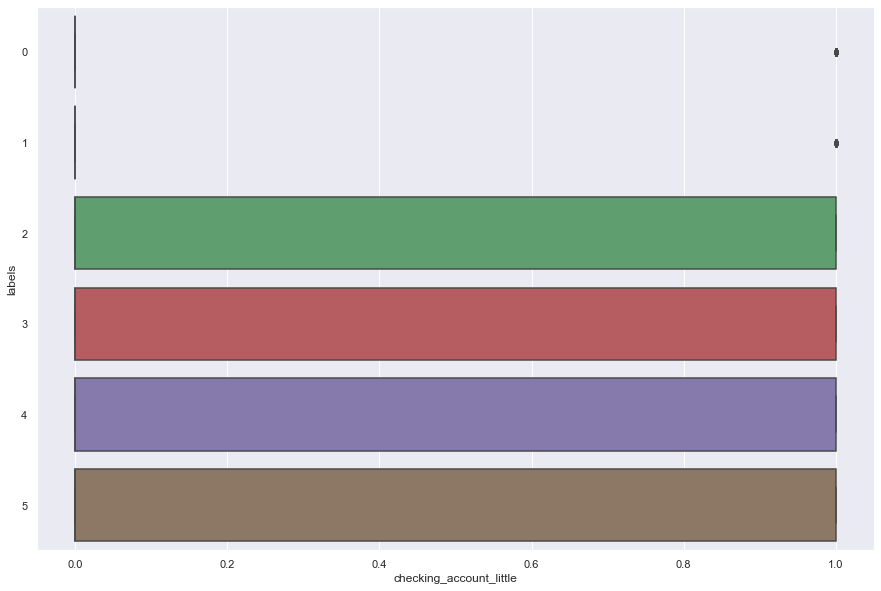

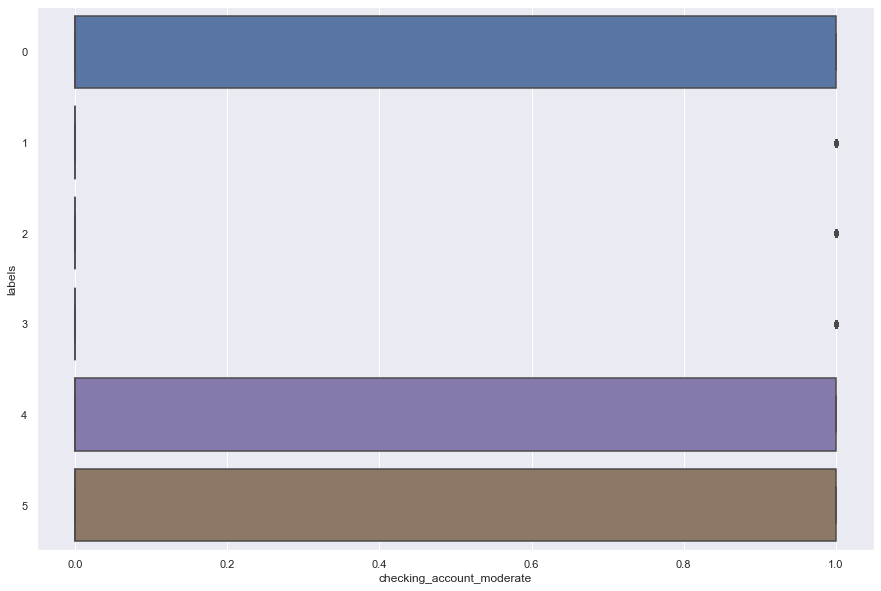

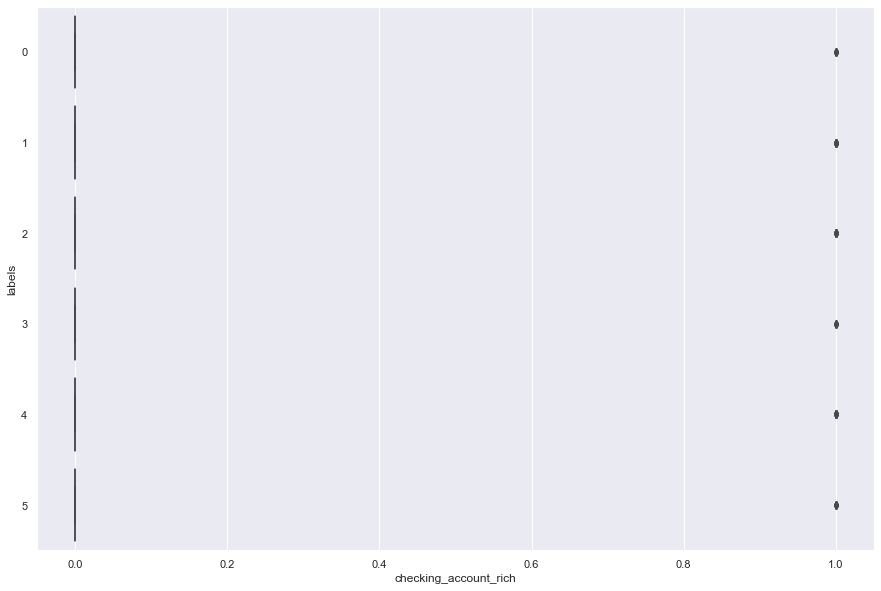

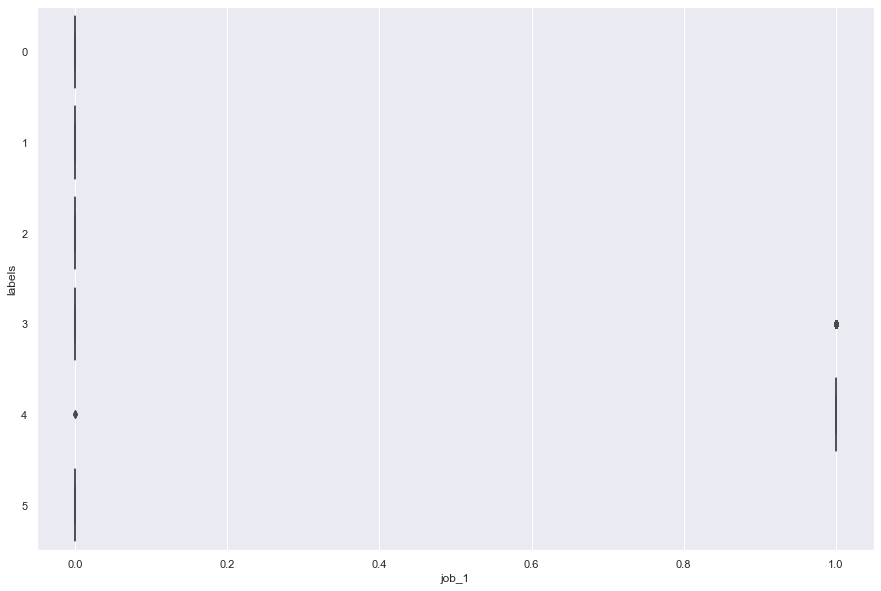

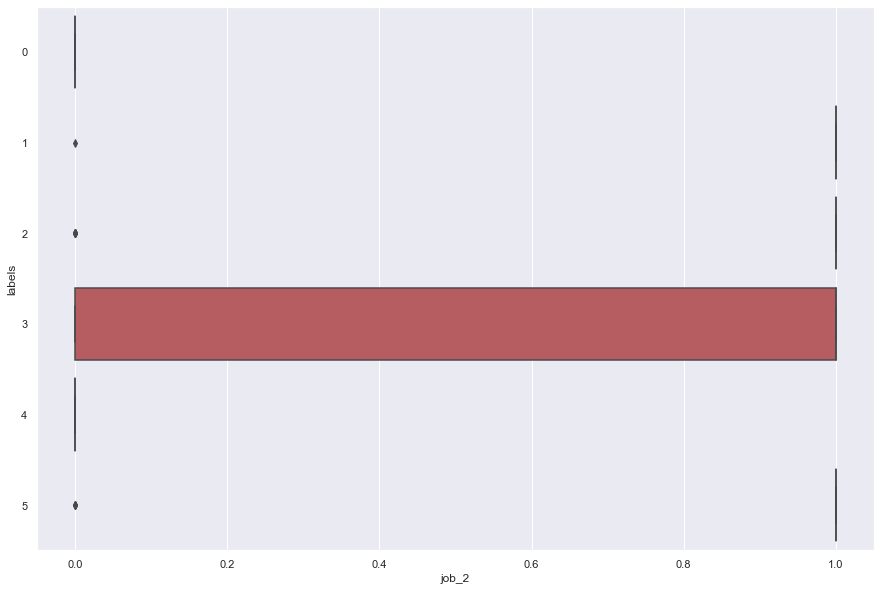

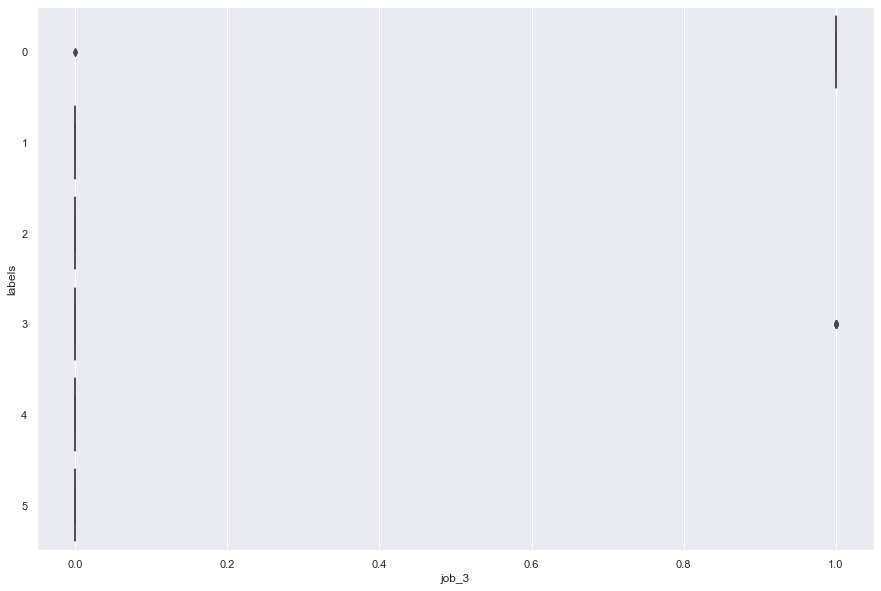

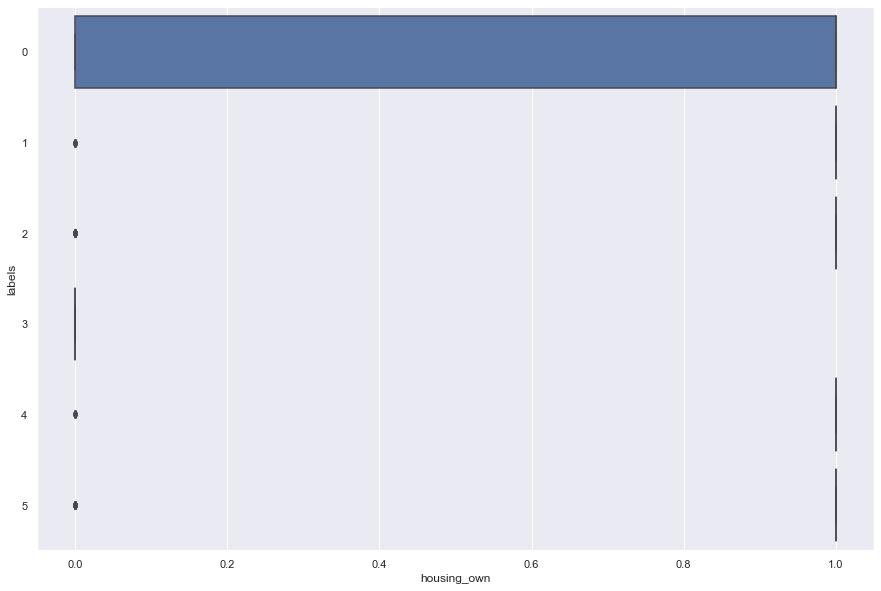

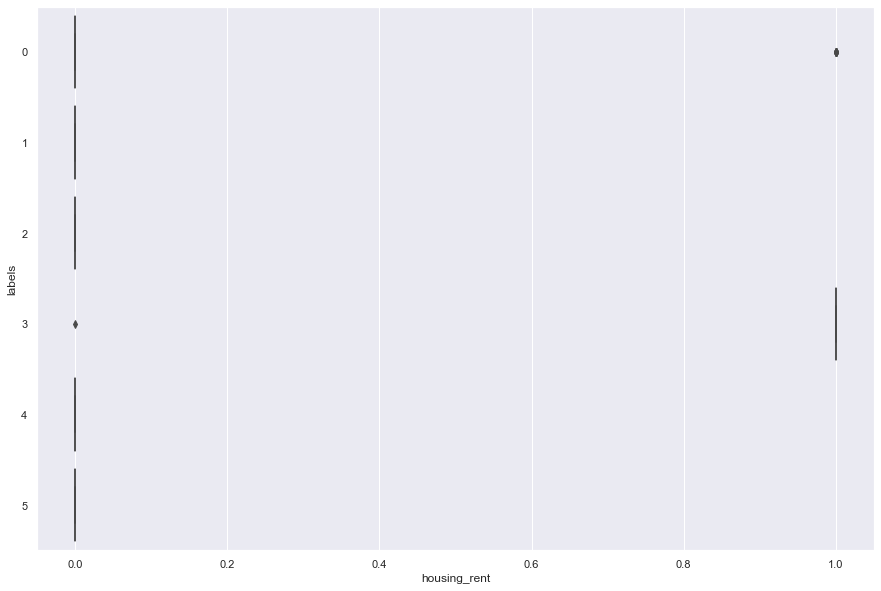

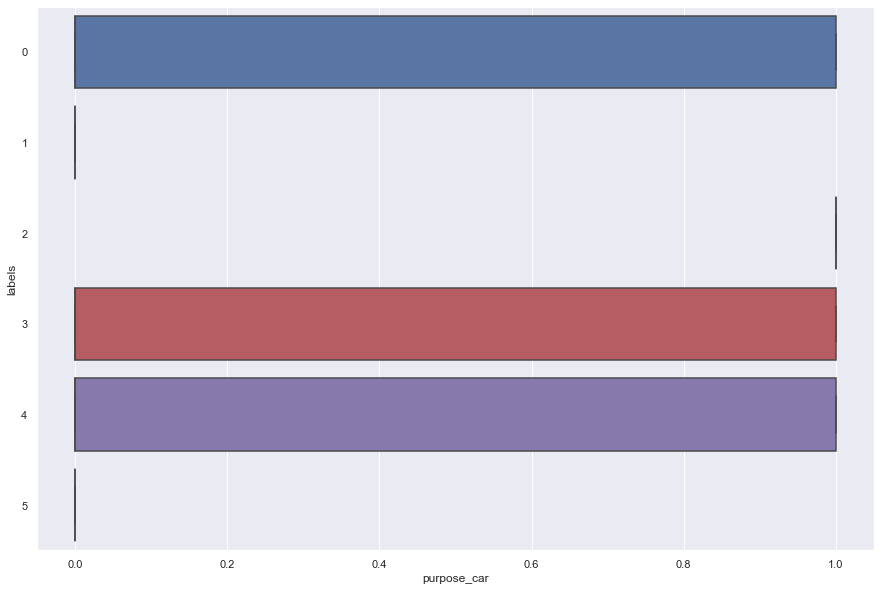

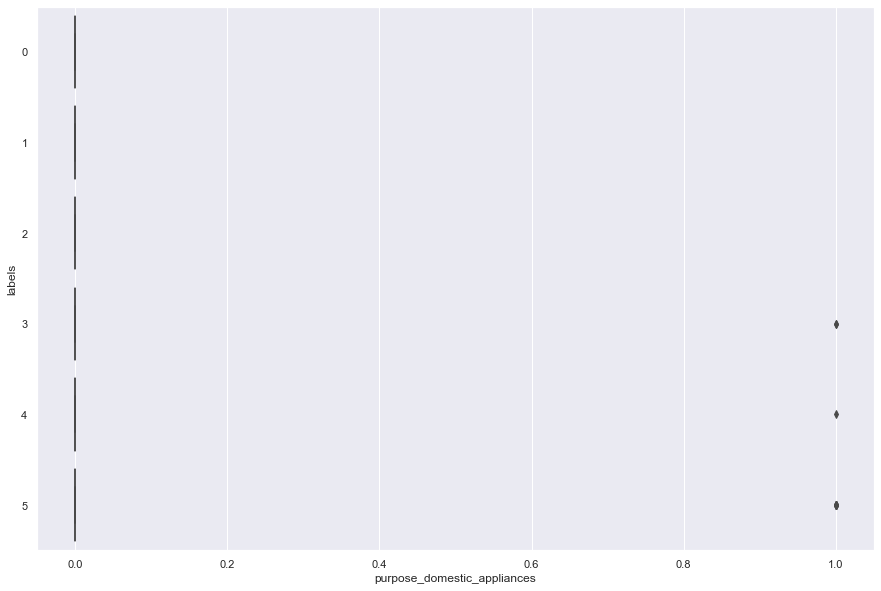

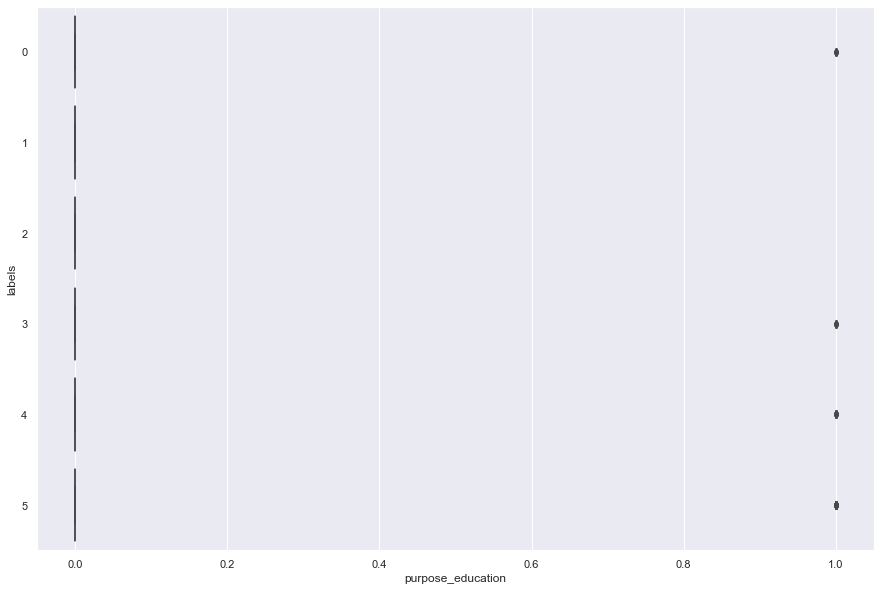

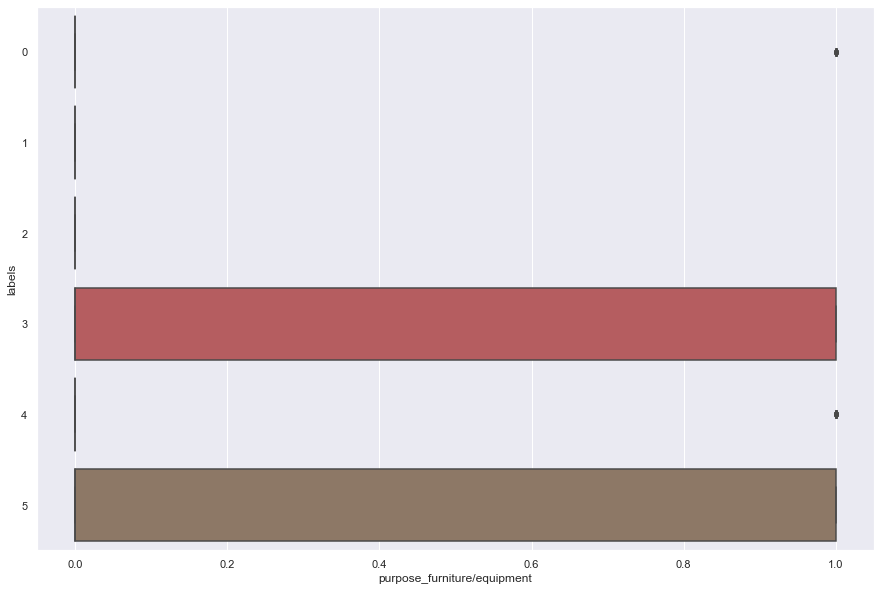

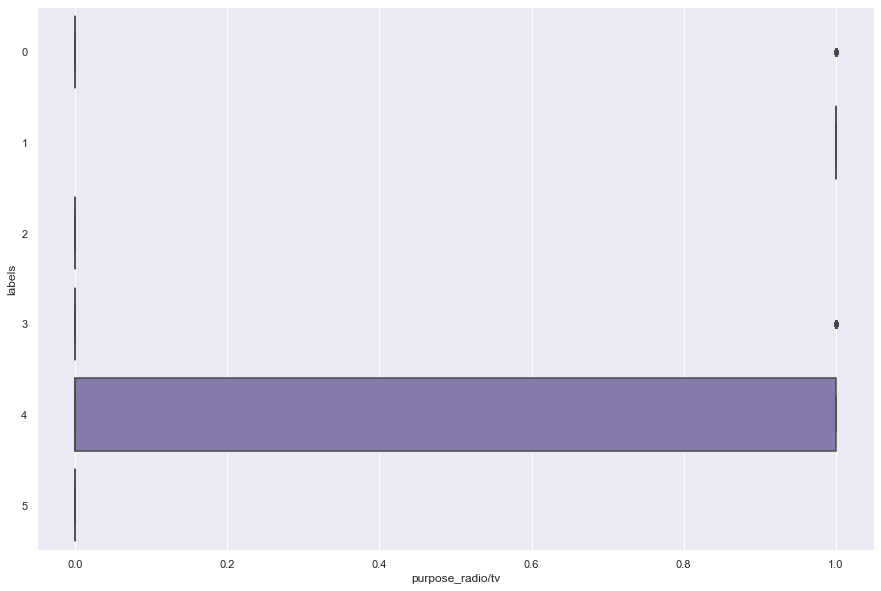

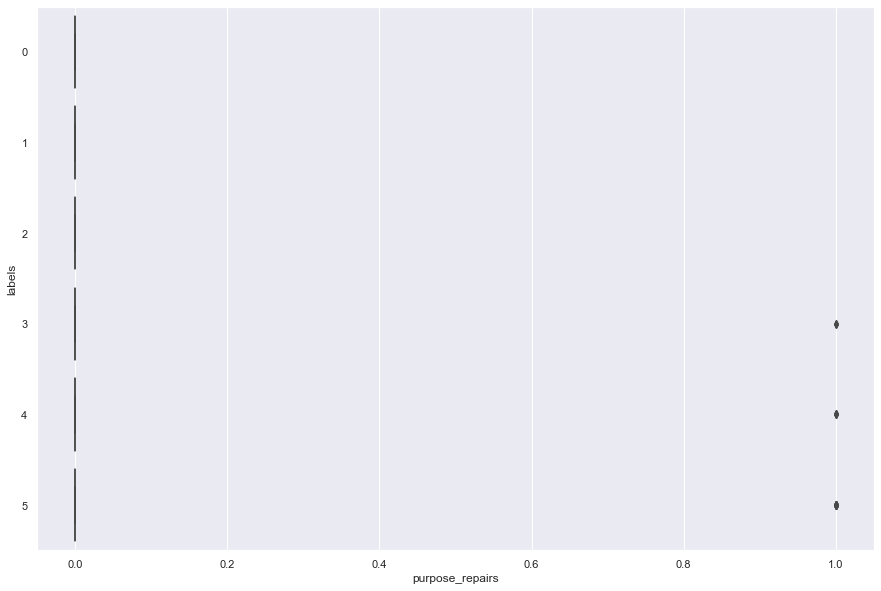

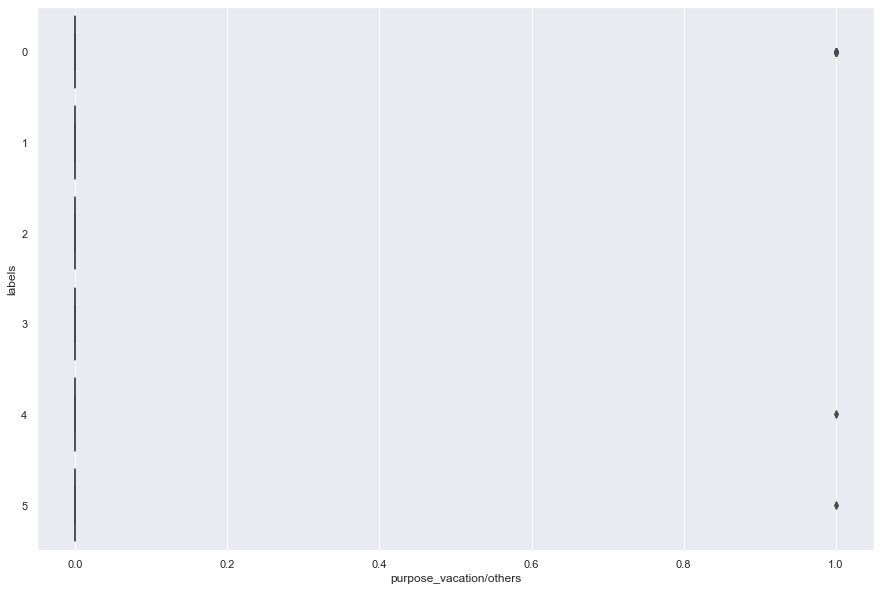

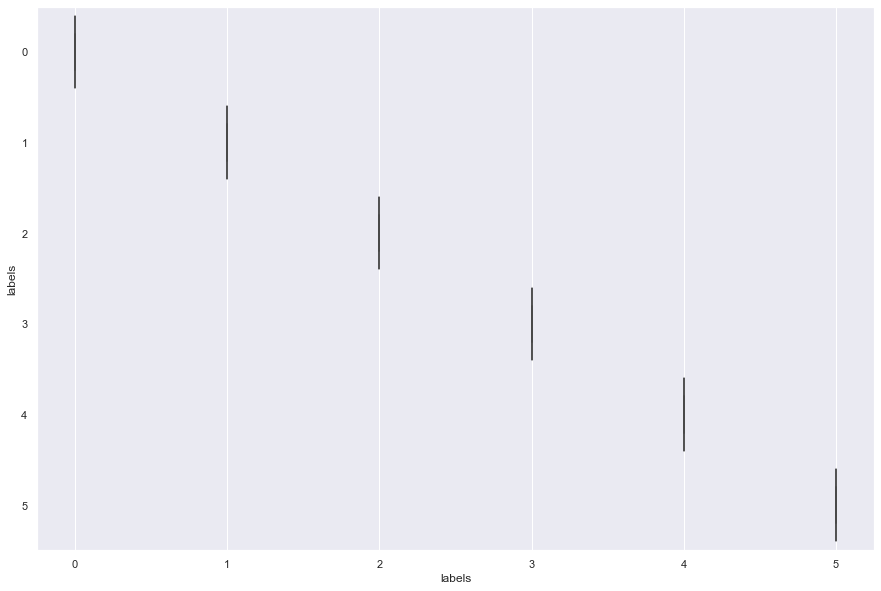

In [36]:
for col in data_kmeans.columns:
    plt.figure(figsize=(15,10))
    sns.boxplot(data=data_kmeans, x=col, y=data_kmeans['labels'], orient='h')

<u>По диаграммам размаха модели кластеризации KMeans можно сделать следующие выводы:</u>
- кластер 0: преобладают мужчины, берут самые крупные кредиты на наибольшую продолжительность, преобладает значение 3 в признаке ”job”;
- кластер 1: преобладают пропуски признаке ”checking_account”, преобладает значение 2 в признаке ”job”, владельцы жилого имущества, берут кредиты на радио/тв;
- кластер 2: преобладает значение 2 в признаке ”job”, владельцы жилого имущества, берут автокредиты;
- кластер 3: наиболее молодые по возрасту, преобладают арендаторы жилого имущества;
- кластер 4: преобладает значение 1 в признаке ”job”, владельцы жилого имущества;
- кластер 5: преобладает значение 2 в признаке ”job”, владельцы жилого имущества.

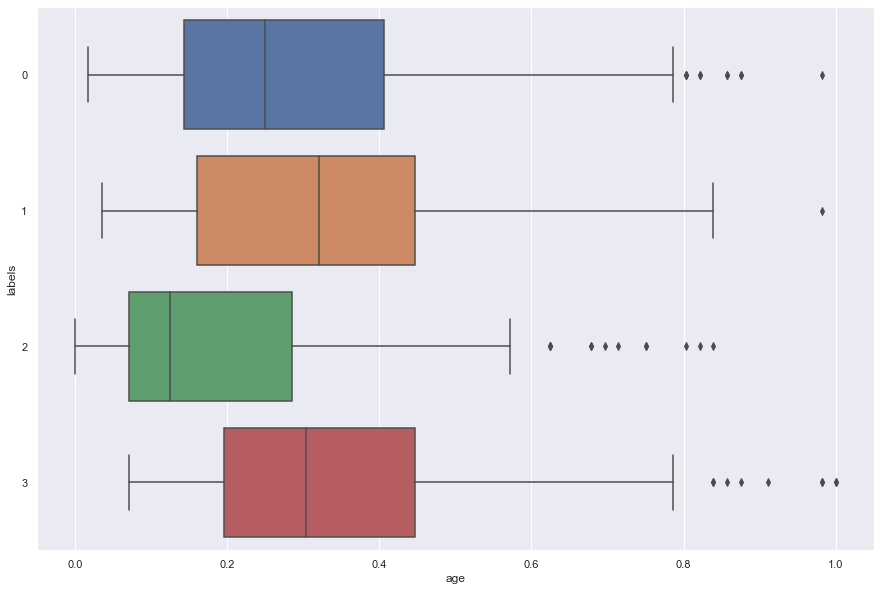

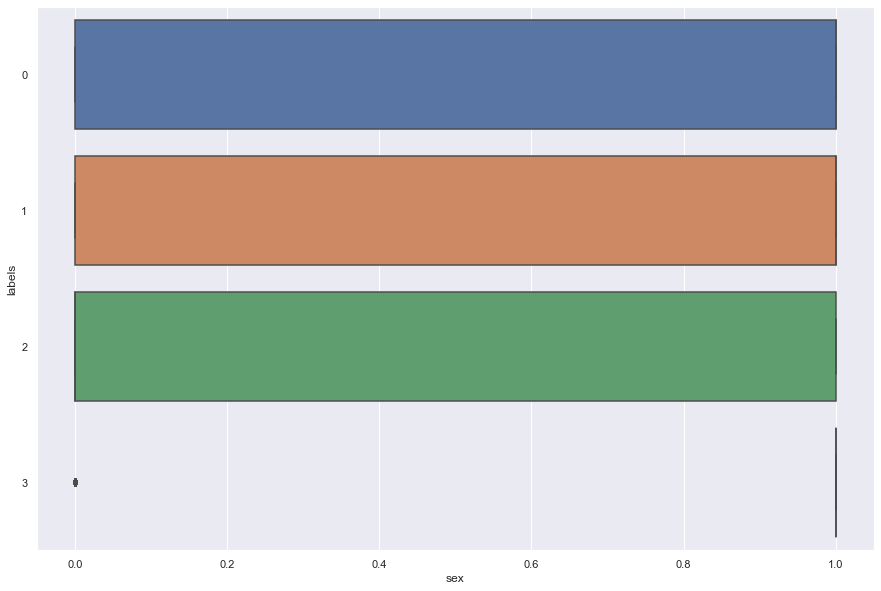

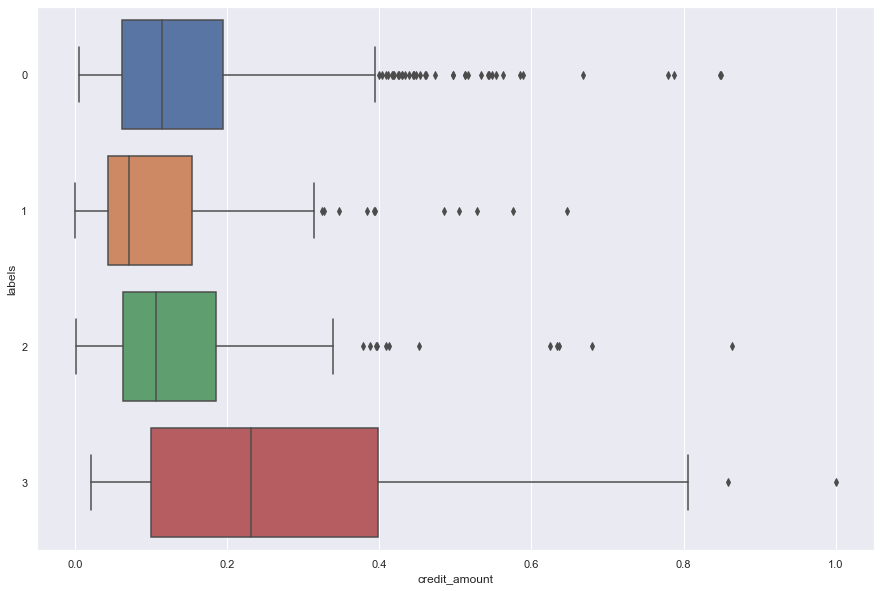

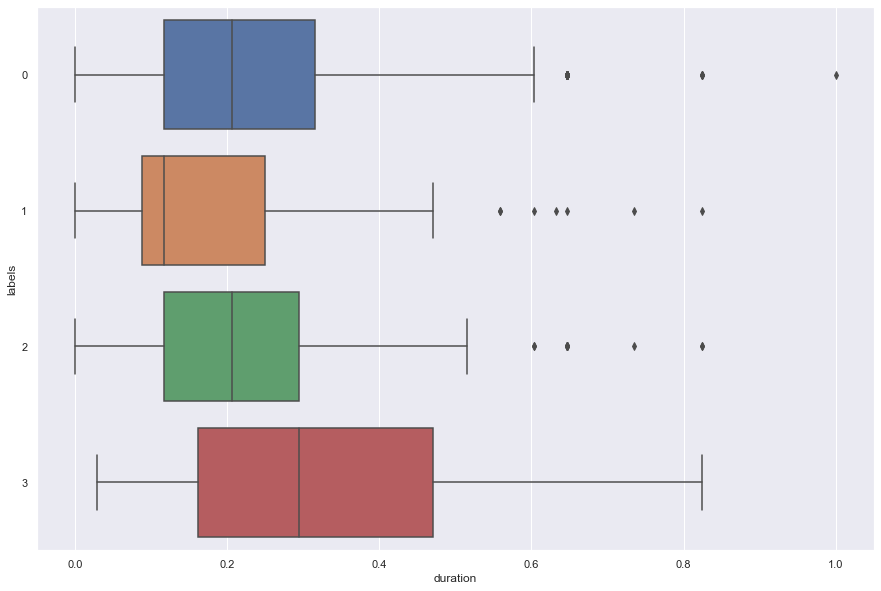

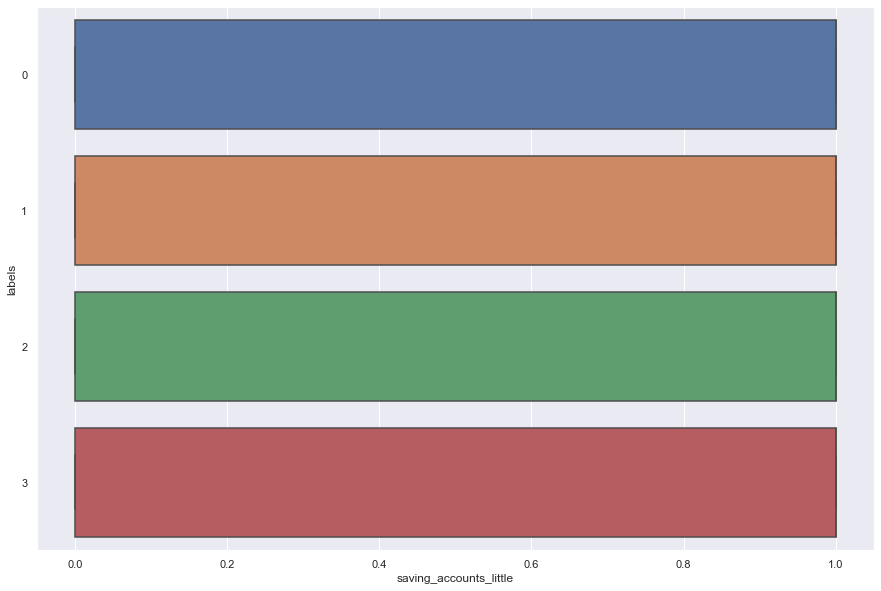

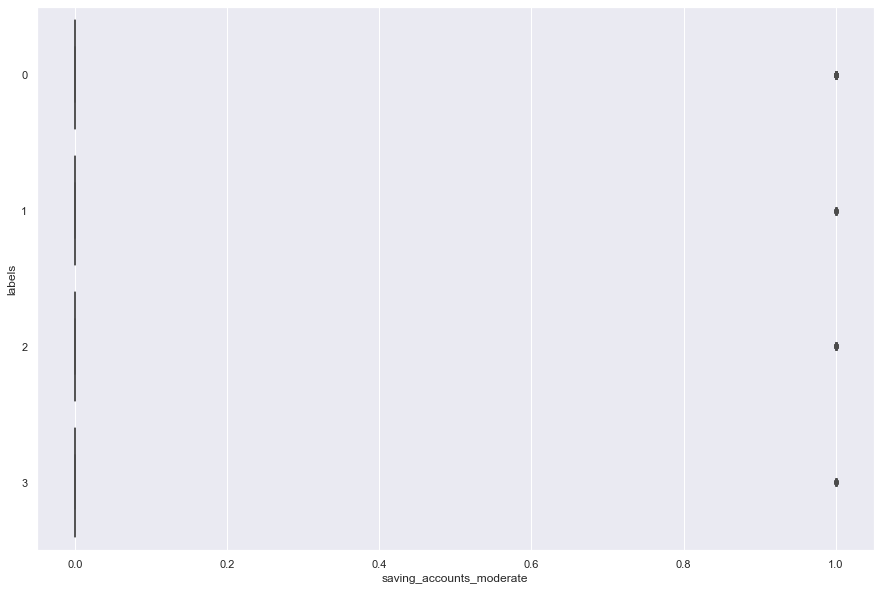

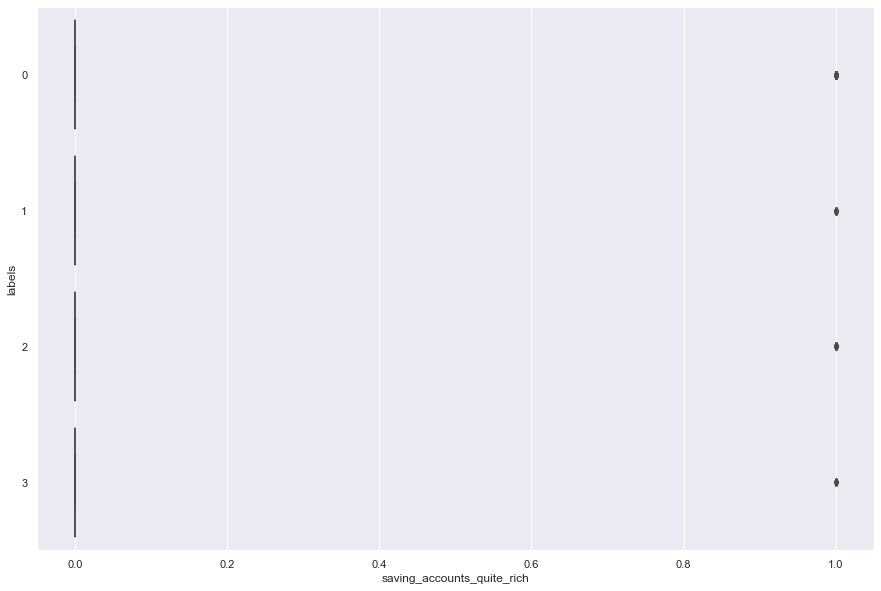

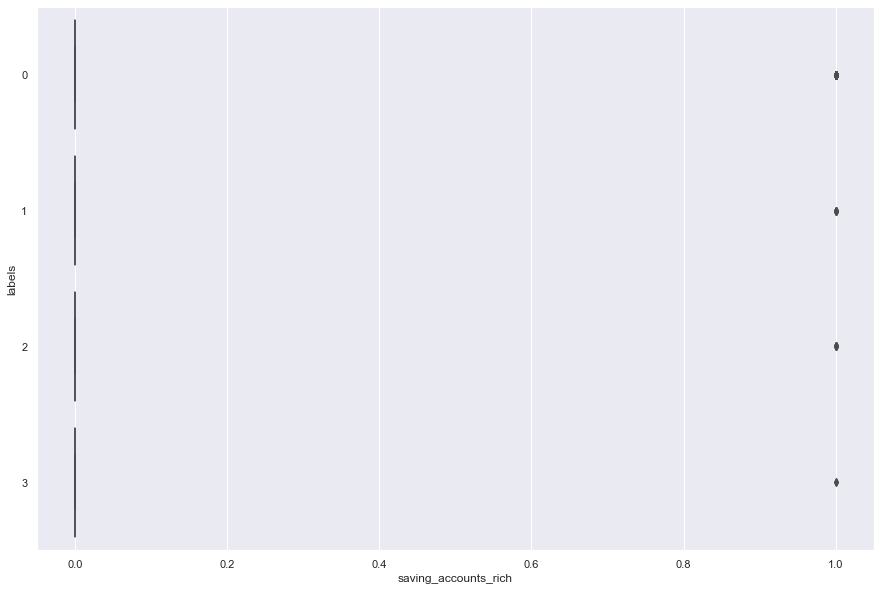

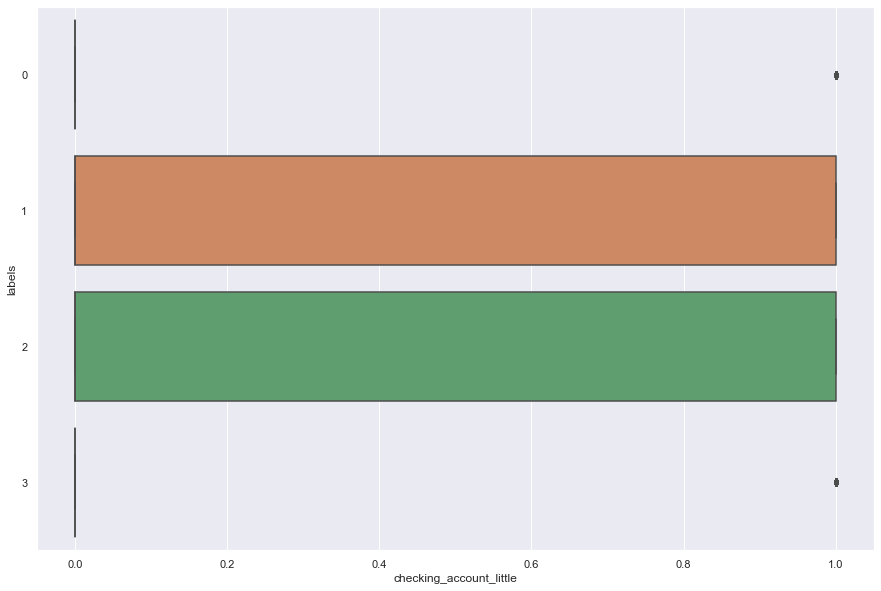

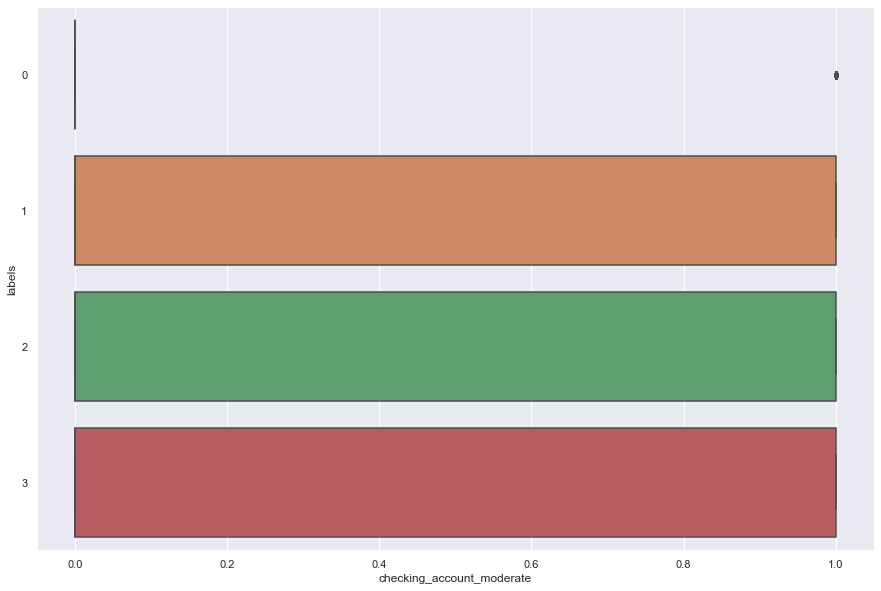

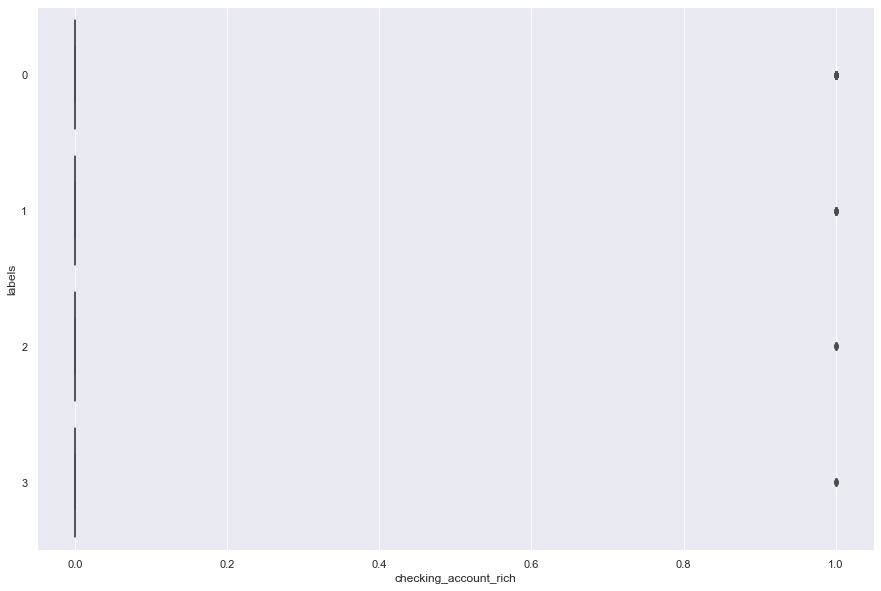

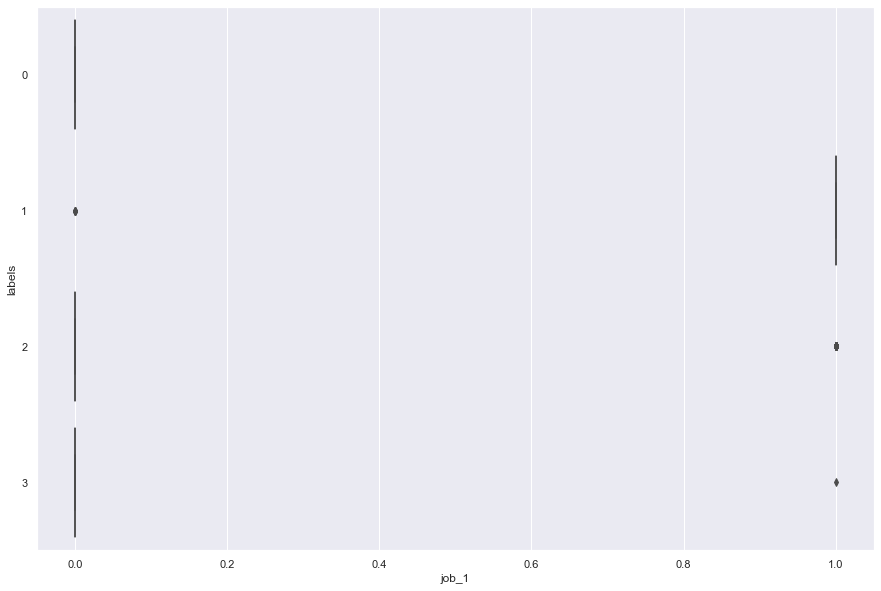

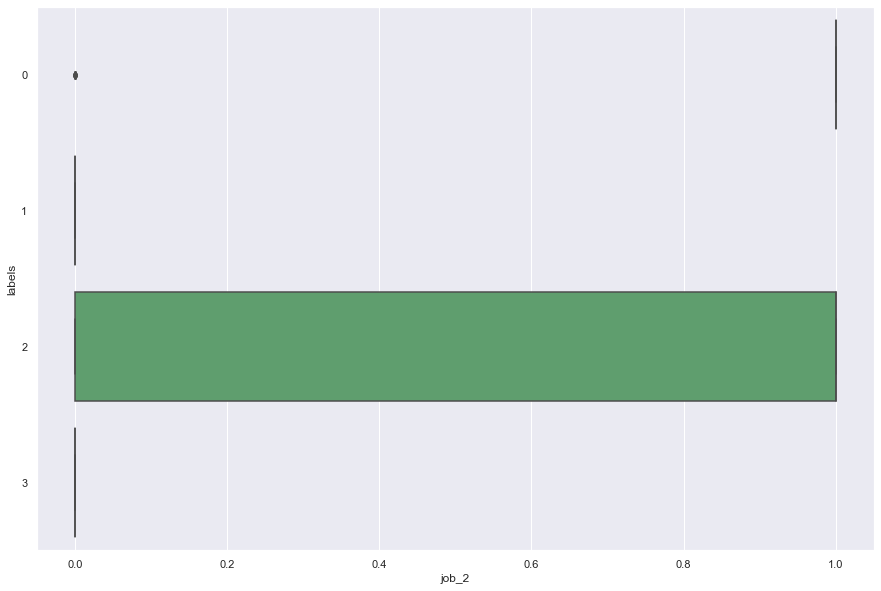

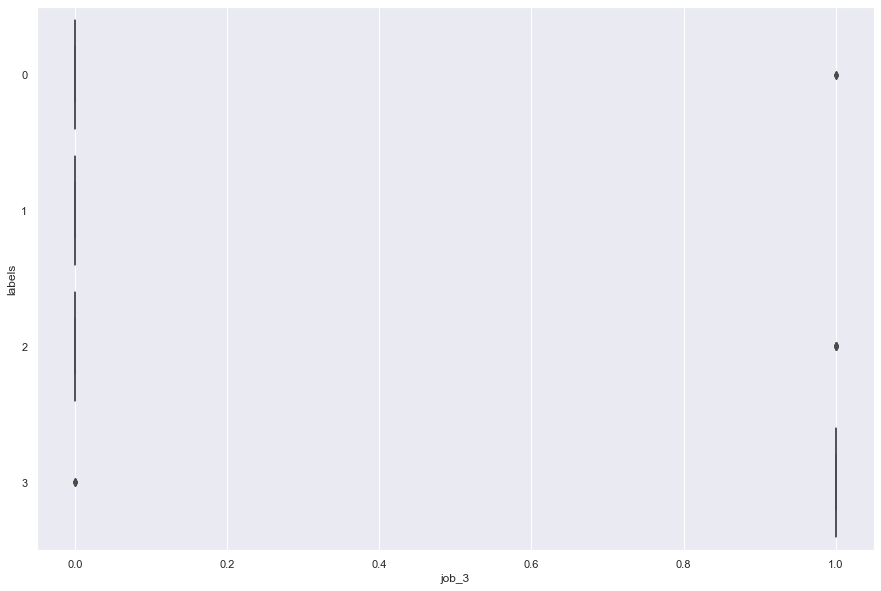

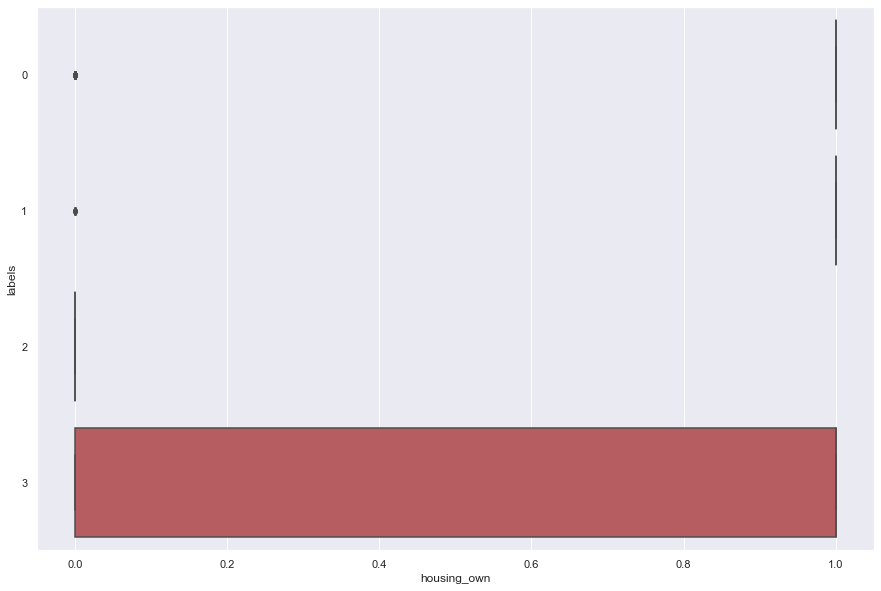

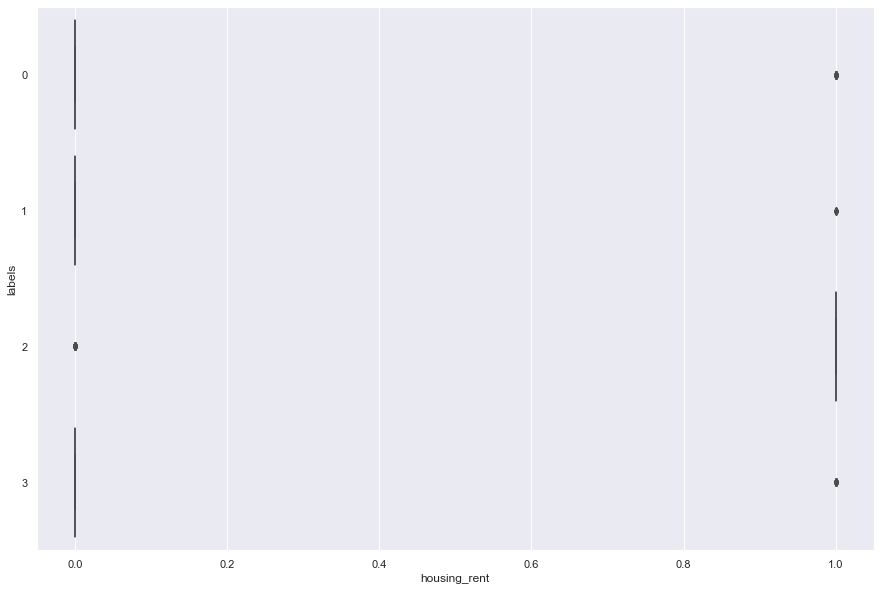

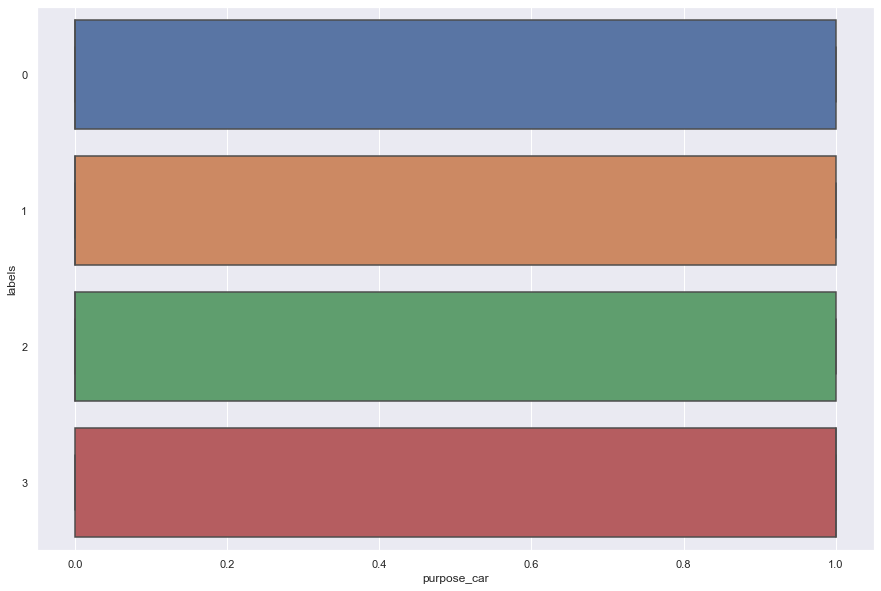

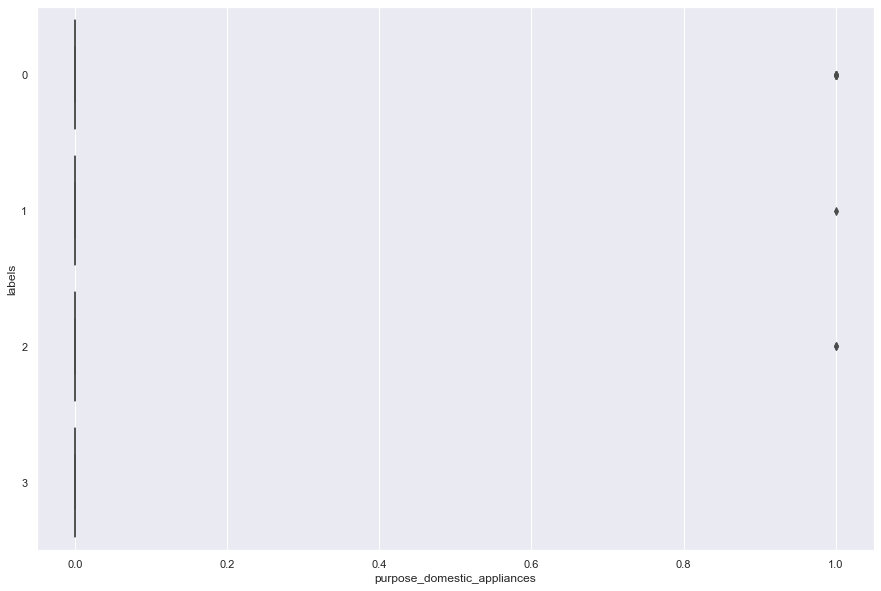

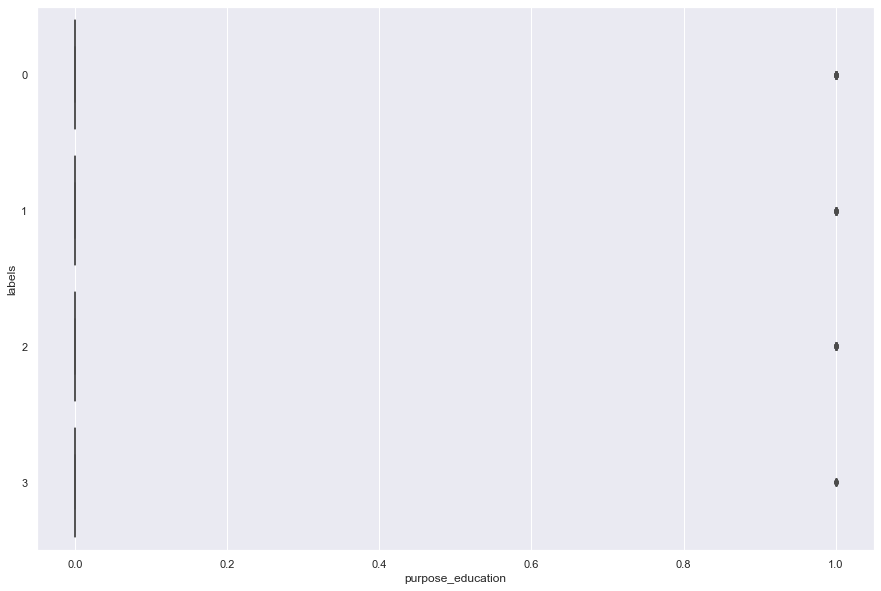

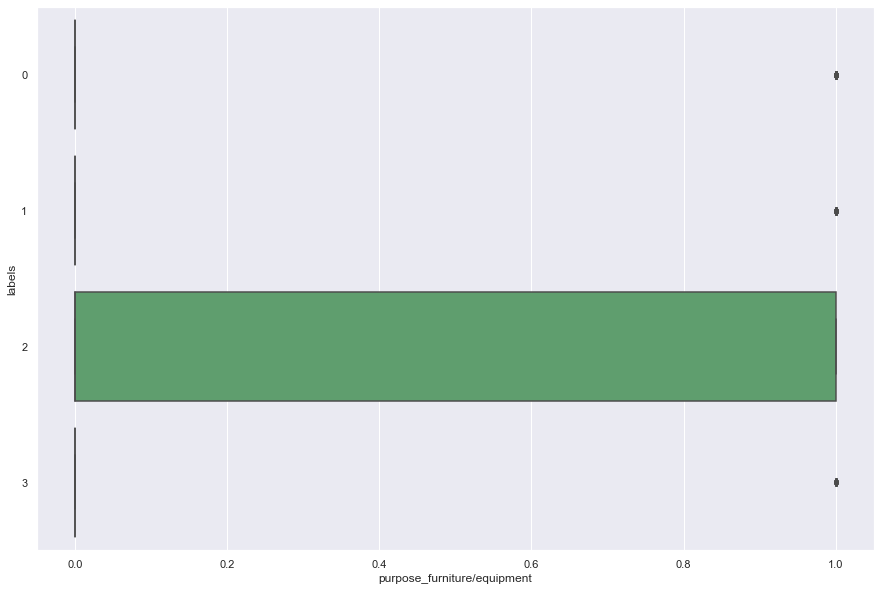

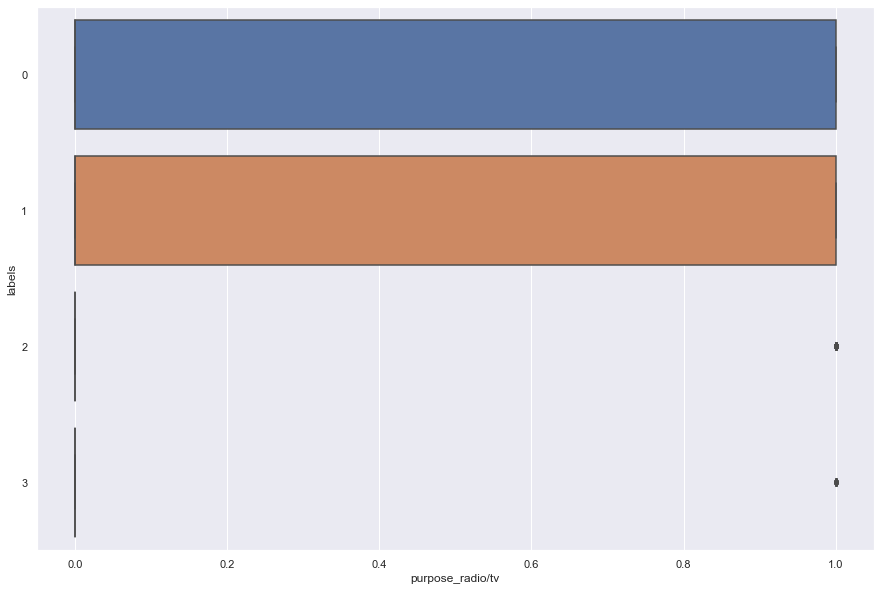

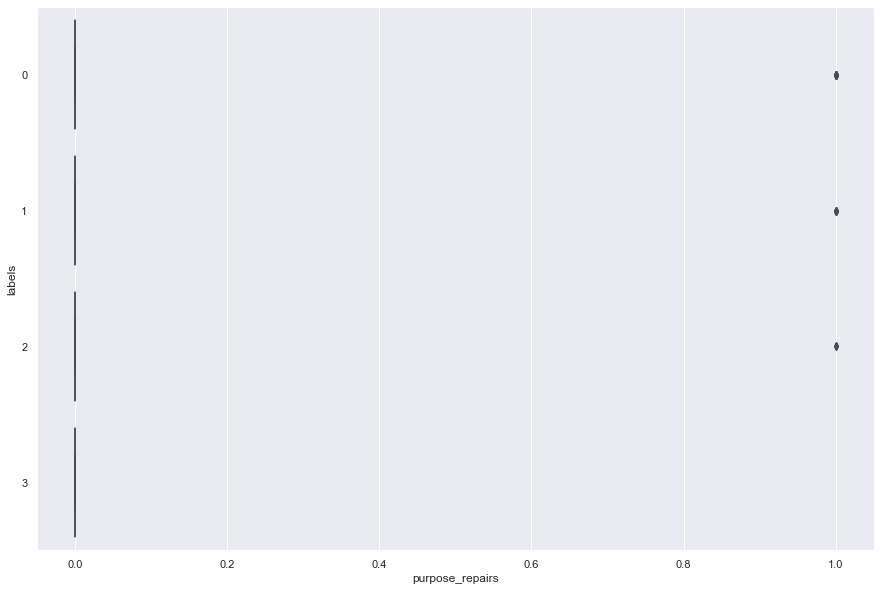

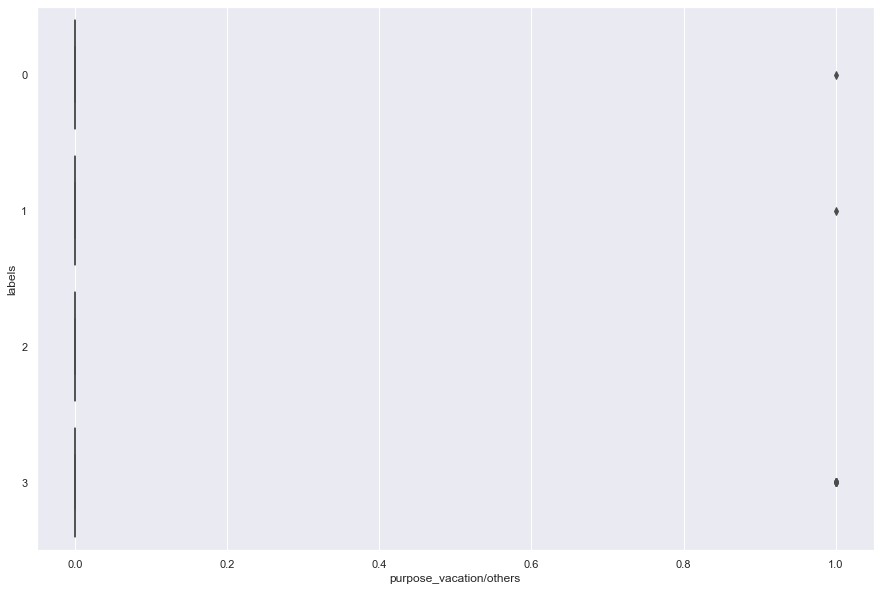

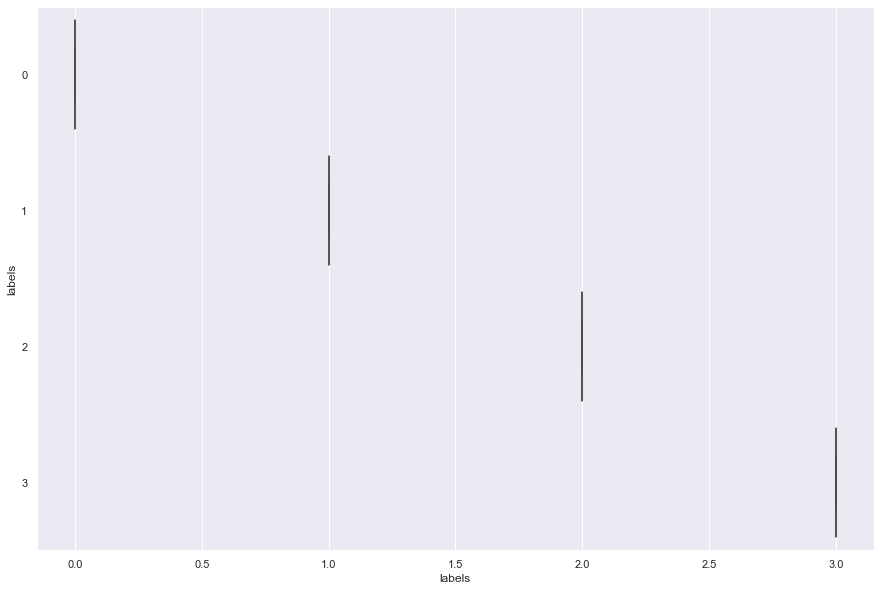

In [44]:
for col in data_agg.columns:
    plt.figure(figsize=(15,10))
    sns.boxplot(data=data_agg, x=col, y=data_agg['labels'], orient='h')

<u>По диаграммам размаха модели кластеризации AgglomerativeClustering
 можно сделать следующие выводы:</u>
- кластер 0: преобладают пропуски признаке ”checking_account”, преобладает значение 2 в признаке ”job”, преобладают владельцы жилого имущества;
- кластер 1: преобладает значение 1 в признаке ”job”, преобладают владельцы жилого имущества;
- кластер 2: наиболее молодые по возрасту, преобладают арендаторы жилого имущества;
- кластер 3: преобладают мужчины, берут самые крупные кредиты на наибольшую продолжительность, преобладает значение 3 в признаке ”job”.

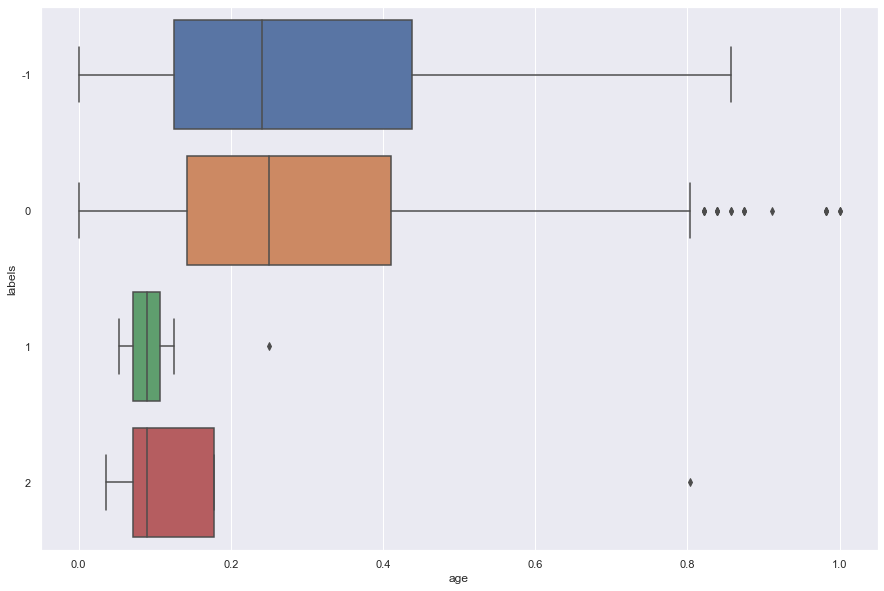

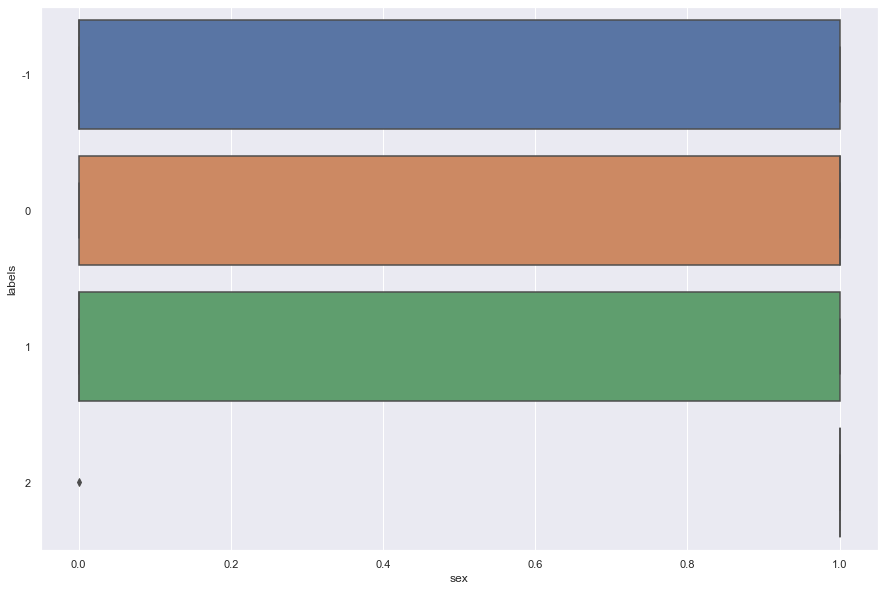

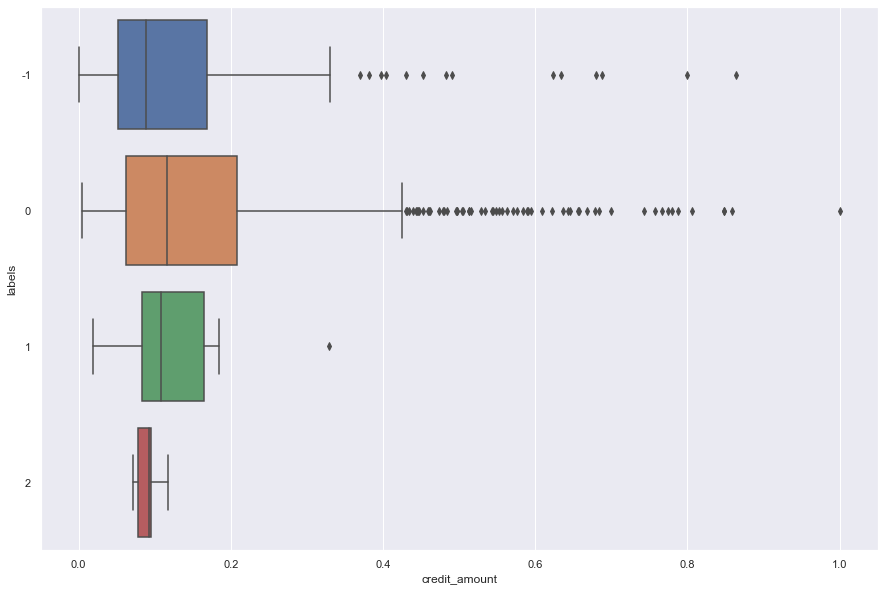

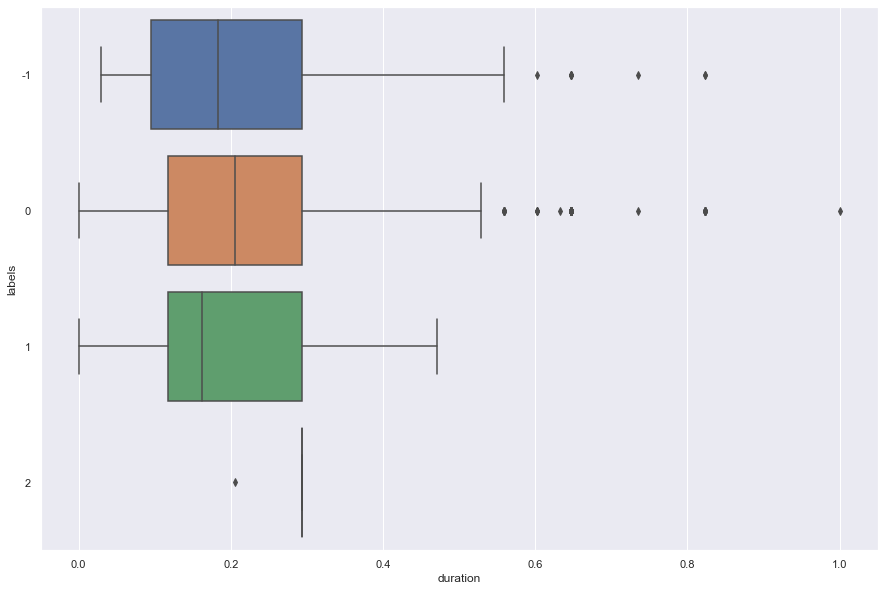

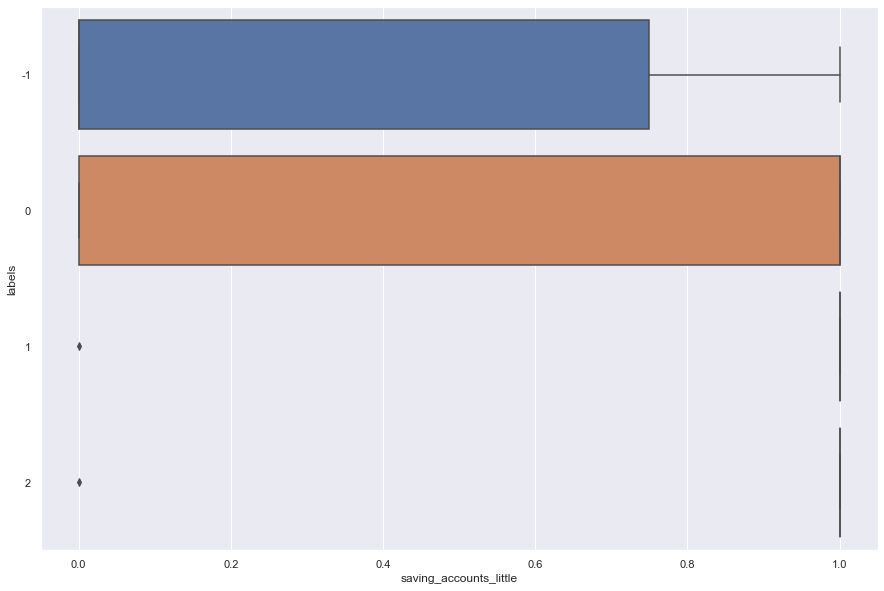

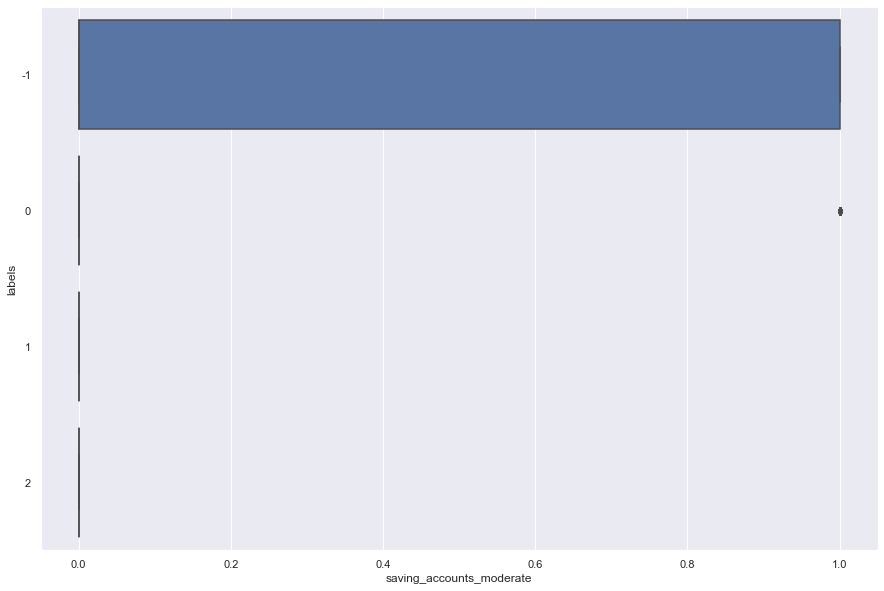

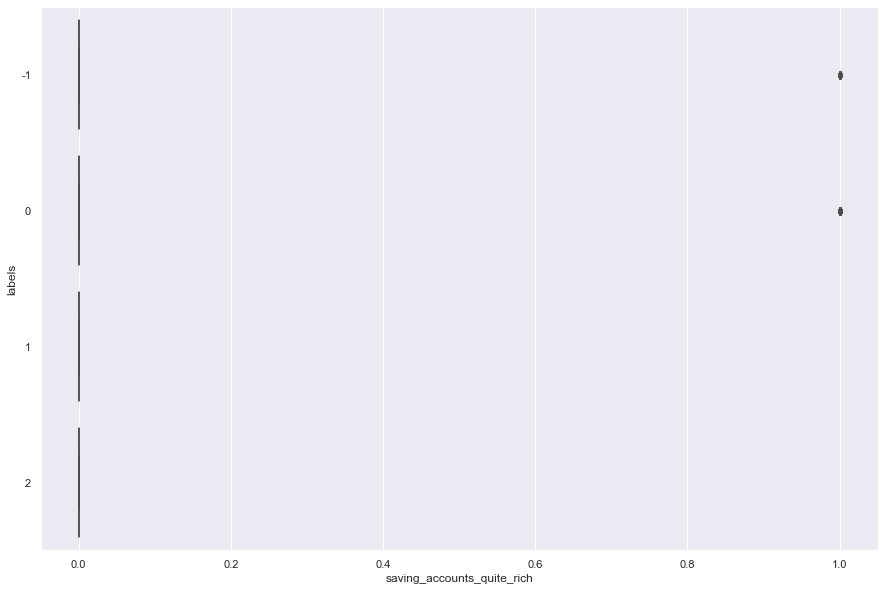

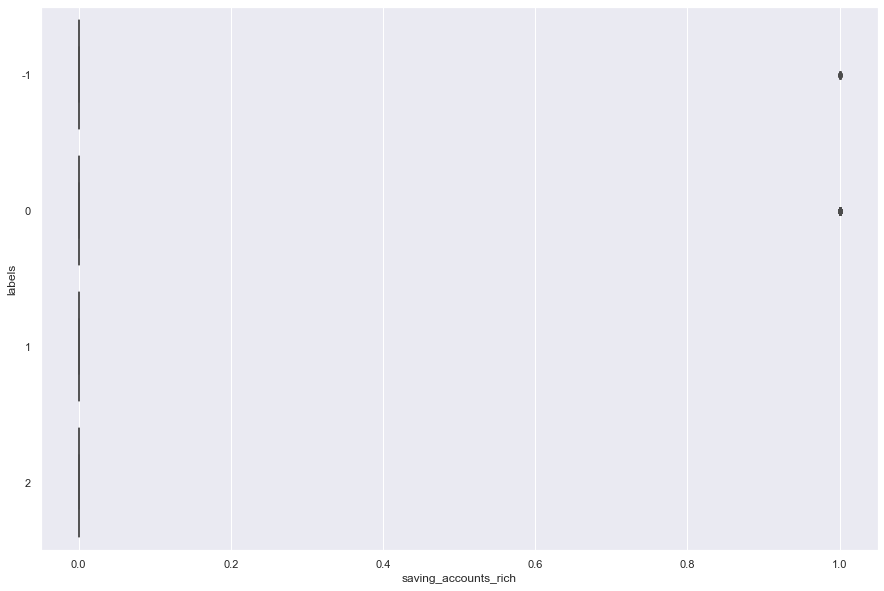

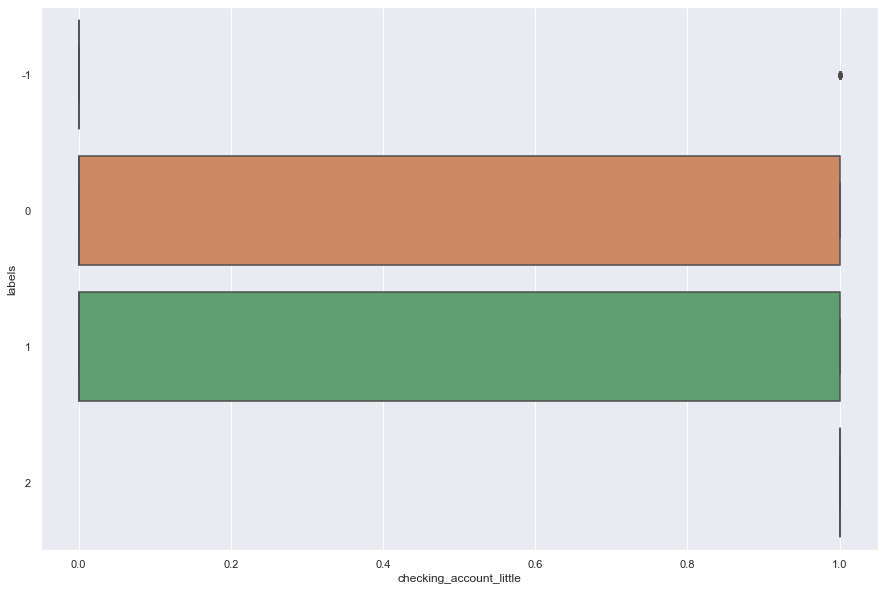

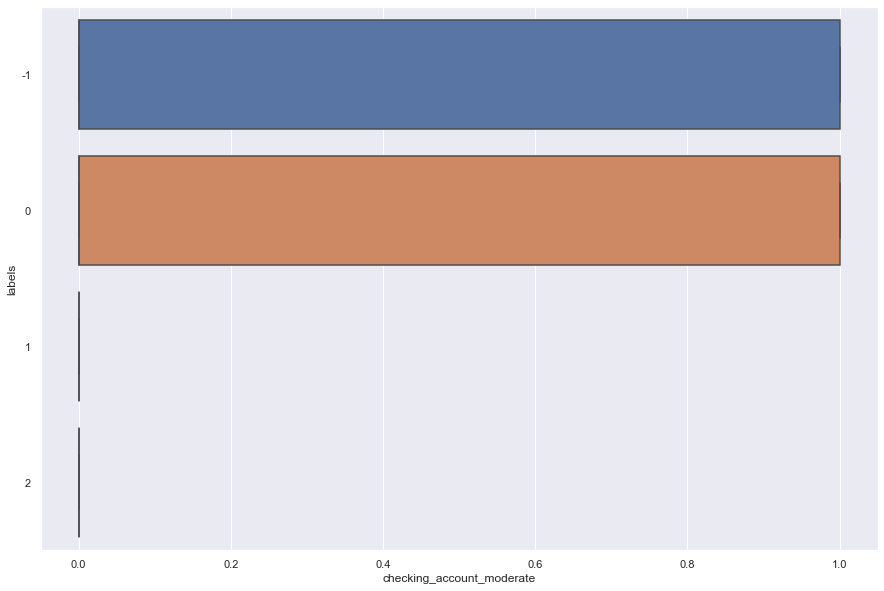

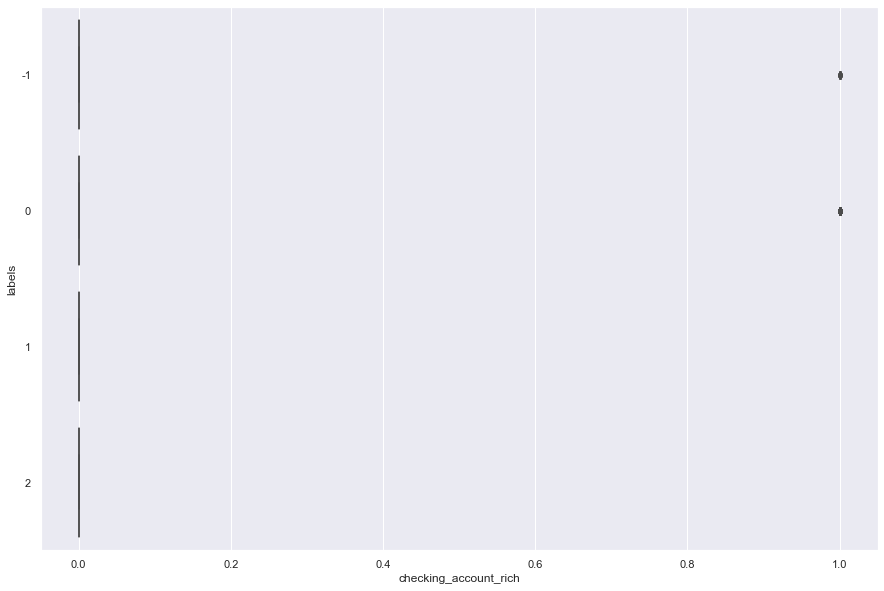

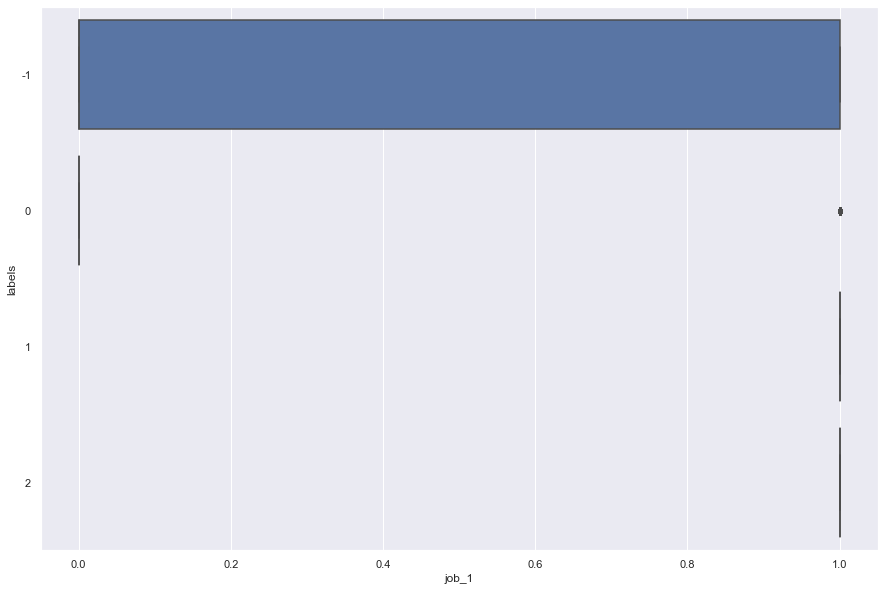

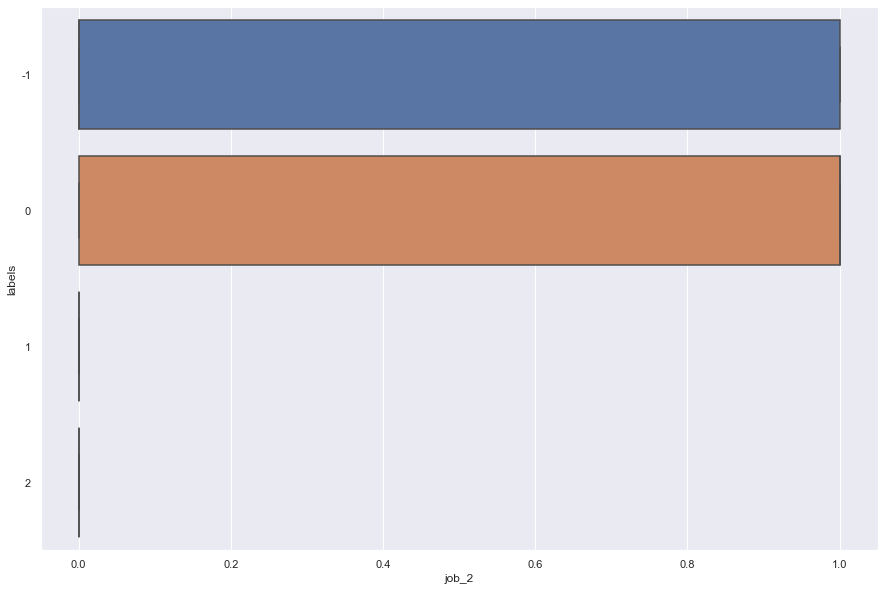

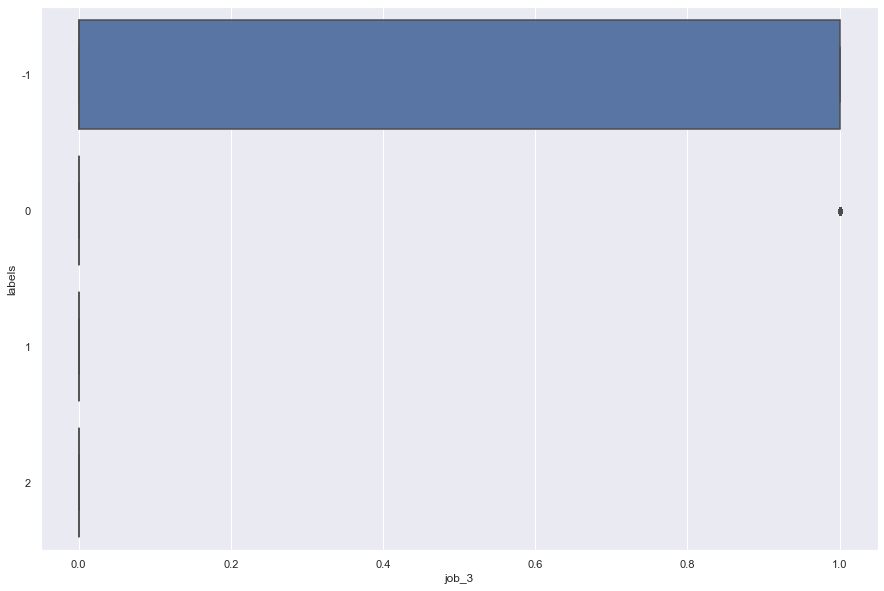

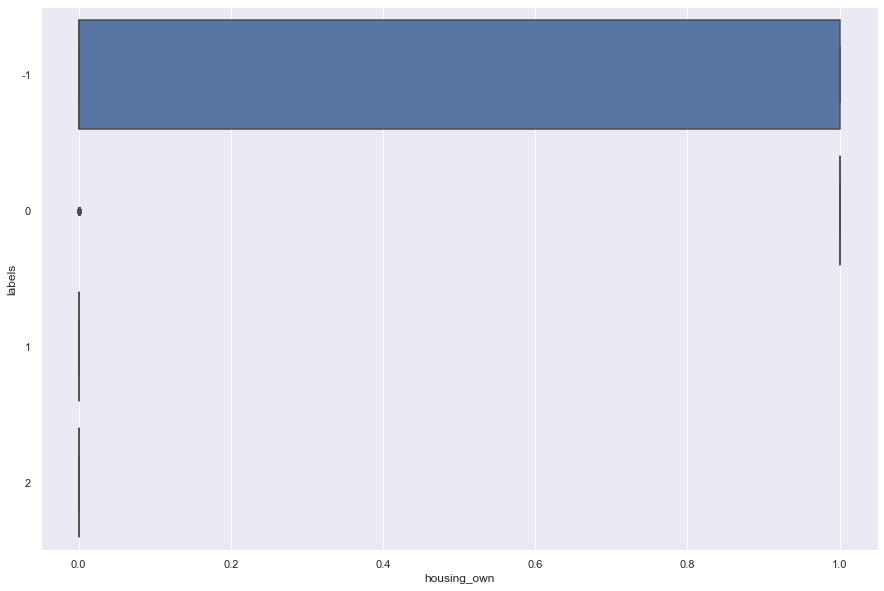

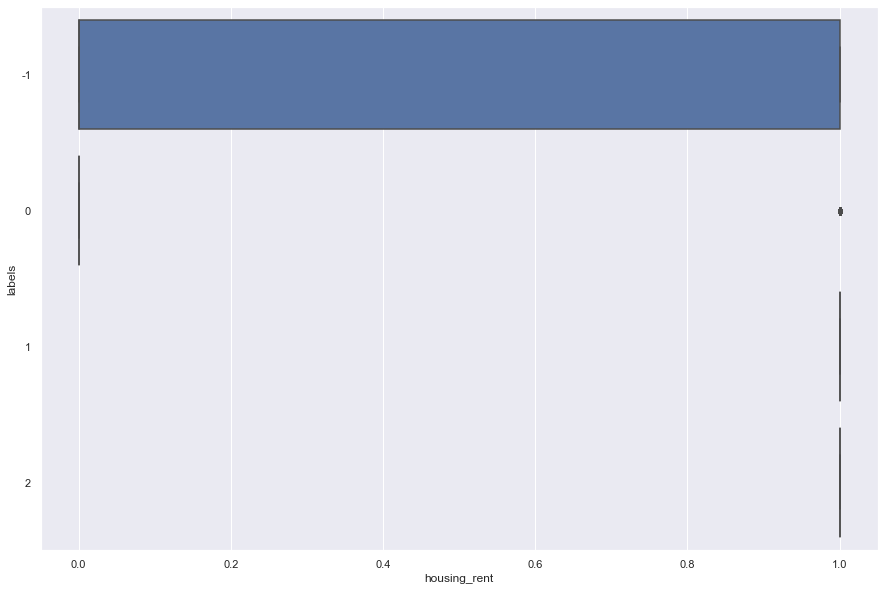

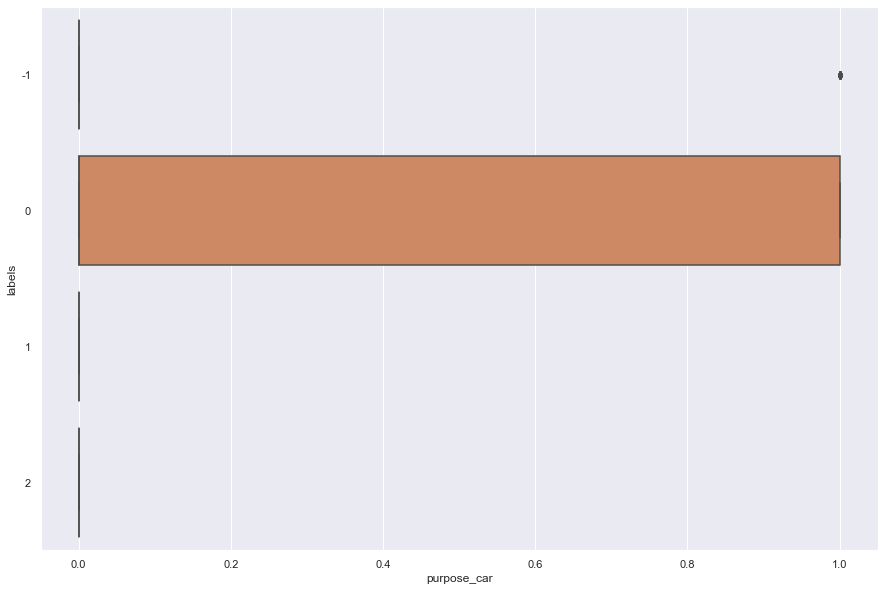

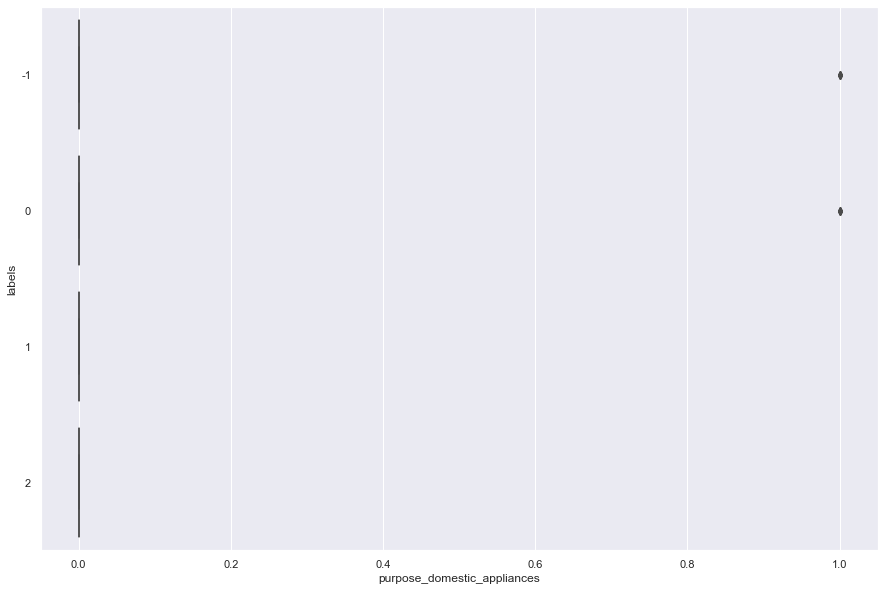

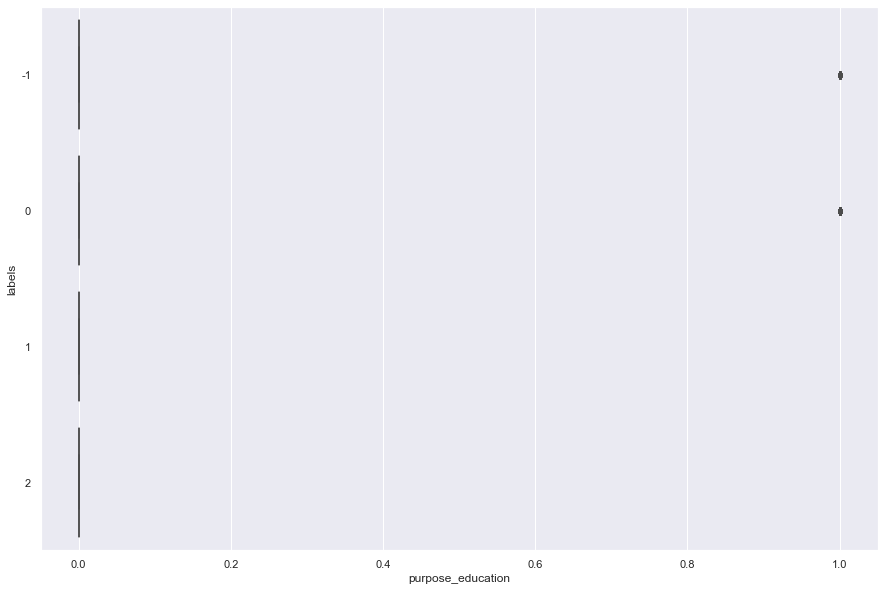

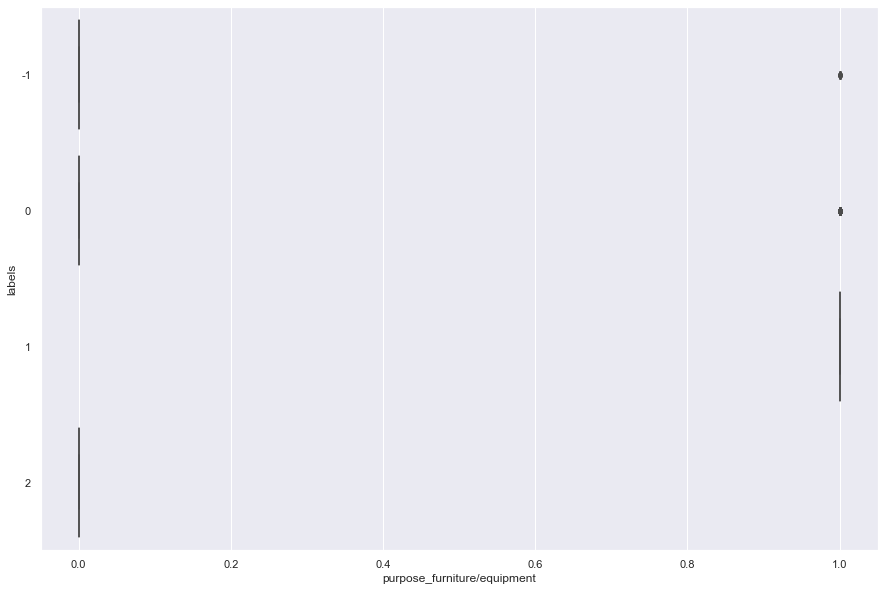

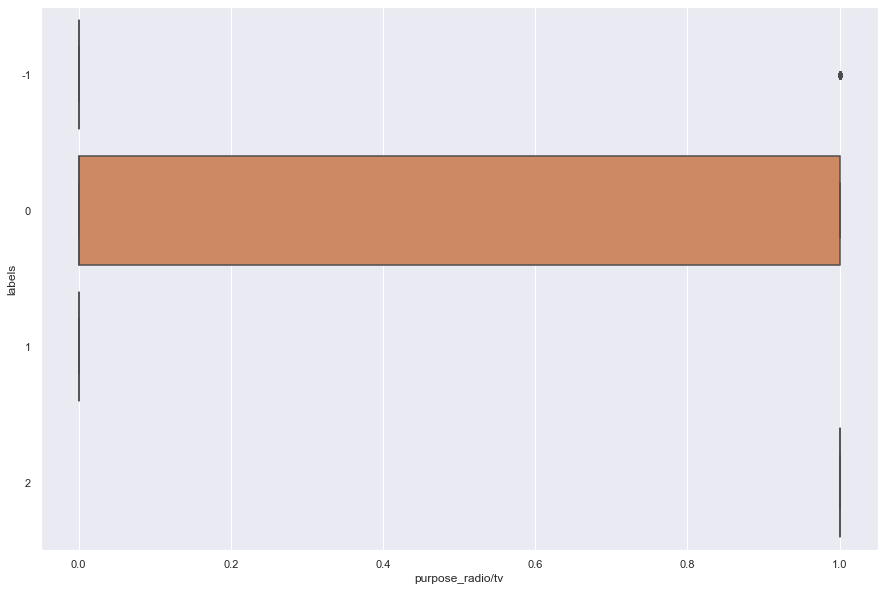

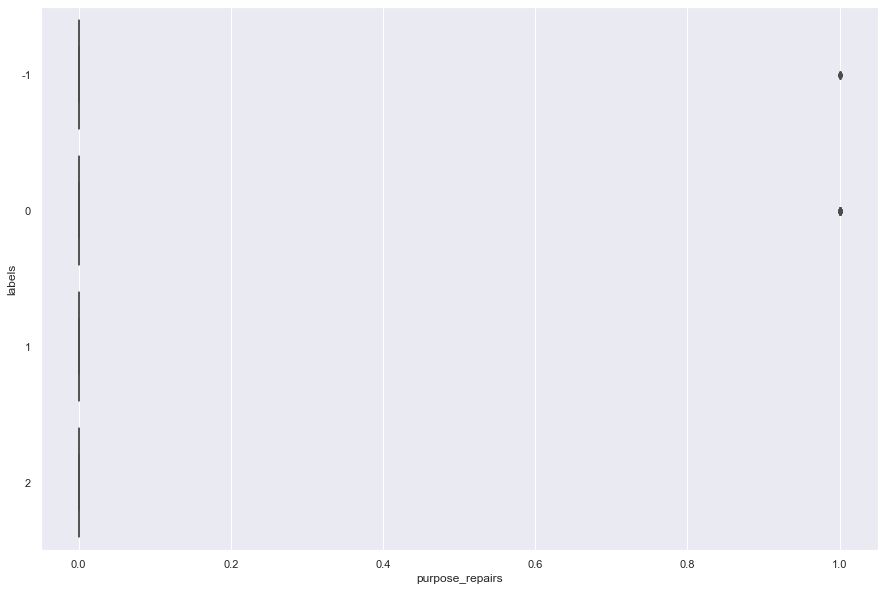

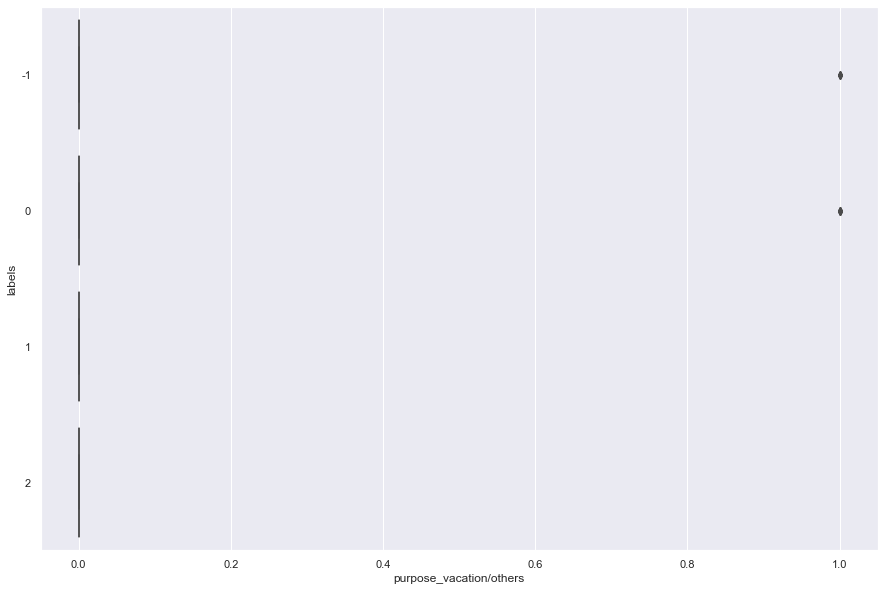

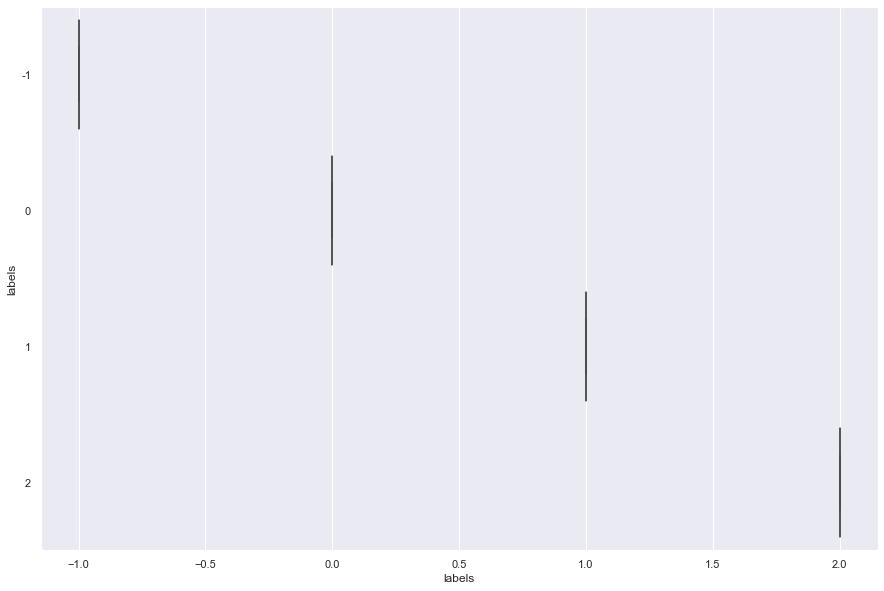

In [45]:
for col in data_dbscan.columns:
    plt.figure(figsize=(15,10))
    sns.boxplot(data=data_dbscan, x=col, y=data_dbscan['labels'], orient='h')

<u> По диаграммам размаха модели кластеризации DBSCAN можно сделать следующие выводы:</u>
- кластер -1 (аномалии): возрастная группа;
- кластер 0: возрастная группа, преобладают владельцы жилого имущества;
- кластер 1: молодая группа, преобладает значение little в признаке ”saving_accounts”, преобладает значение 1 в признаке ”job”, преобладают арендаторы жилого имущества, берут кредиты на фурнитуру/оборудование;
- кластер 2: молодая группа, преобладают мужчины, берут кредит на один и тот же срок, преобладает значение little в признаке ”saving_accounts”, преобладает значение little в признаке ”checking_account”, преобладает значение 1 в признаке ”job”, преобладают арендаторы жилого имущества, берут кредиты на радио/тв.

### <font color='aquamarine'>Модели KMeans и AgglomerativeClustering получились со схожими признаками кластеров.